In [183]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display
from pathlib import Path
import sys

sns.set_theme(style="whitegrid", palette="colorblind")
pd.set_option("display.max_columns", 30)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

Importando nossos scripts de apoio

In [184]:
# Adicionando o diretório scripts ao path do Python

scripts_dir = Path.cwd() / "scripts"
if str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))

import read_excel_sheets as les
import exploratory as expl
import estatisticas as estat

Selecionando as planilhas relevantes

In [185]:
BASE_DIR = Path("pisa2018")
STU_FILE = BASE_DIR / "stu" / "STU_BRA.xlsx"
FLT_FILE = BASE_DIR / "flt" / "FLT_BRA.xlsx"
SCH_FILE = BASE_DIR / "sch" / "SCH_BRA.xlsx"

for path in (STU_FILE, FLT_FILE, SCH_FILE):
    assert path.exists(), f"Arquivo não encontrado: {path}"

Conferindo as abas disponíveis em cada planilha

In [186]:
les.inspect_workbook(STU_FILE)
les.inspect_workbook(FLT_FILE)
les.inspect_workbook(SCH_FILE)

STU_BRA.xlsx -> abas disponíveis: ['data.with.lbl', 'data', 'fields']
FLT_BRA.xlsx -> abas disponíveis: ['data.with.lbl', 'data', 'fields']
SCH_BRA.xlsx -> abas disponíveis: ['data.with.lbl', 'data', 'fields']


## Features Relevantes

Selecionaremos as colunas abaixo, apenas das abas `data` de cada planilha.
- `STU_BRA.xlsx` fornece os indicadores de aluno (`ESCS`, `DISCLIMA`, `BELONG`, gênero, repetência etc.).
- `FLT_BRA.xlsx` agrega os escores plausíveis de leitura (`READ`) e os pesos amostrais (`SENWT`). Os identificadores (`CNTSTUID`) aparecem deslocados em +50.000 e são alinhados manualmente.
- `SCH_BRA.xlsx` traz índices de contexto escolar (`EDUSHORT`, `STAFFSHORT`), além da composição de financiamento (`SC016Qxx`).


Selecionando as colunas relevantes em cada planilha


In [187]:
STU_COLS = [
    "CNTSTUID", "CNTSCHID", "ESCS", "DISCLIMA", "BELONG",
    "ST004D01T", "REPEAT", "SCIE", "SCIE.SE"
]

FLT_COLS = [
    "CNTSTUID", "CNTSCHID", "SENWT", "READ", "READ.SE",
    "MATH", "MATH.SE", "JOYREAD", "SCREADCOMP"
]

SCH_COLS = [
    "CNTSCHID", "SC013Q01TA", "SC016Q01TA", "SC016Q02TA",
    "EDUSHORT", "STAFFSHORT"
]


Criando os dataframes

In [188]:
stu = les.load_sheet(STU_FILE, STU_COLS)
flt = les.load_sheet(FLT_FILE, FLT_COLS)
sch = les.load_sheet(SCH_FILE, SCH_COLS)

stu.shape, flt.shape, sch.shape

((10691, 9), (8311, 9), (597, 6))

In [189]:
math_pv_cols = [col for col in flt.columns if col.startswith("PV") and col.endswith("MATH")]
science_pv_cols = [col for col in flt.columns if col.startswith("PV") and col.endswith("SCIE")]

if math_pv_cols:
    flt["MATH"] = flt[math_pv_cols].mean(axis=1)
    flt["MATH.SE"] = flt[math_pv_cols].std(axis=1, ddof=1)
else:
    print("FLT_BRA.xlsx não traz valores plausíveis de matemática; usaremos a coluna `MATH` já sintetizada pela OCDE.")

if science_pv_cols:
    flt["SCIENCE"] = flt[science_pv_cols].mean(axis=1)
    flt["SCIENCE.SE"] = flt[science_pv_cols].std(axis=1, ddof=1)
else:
    print("Valores plausíveis de ciências não estão disponíveis no FLT; usaremos `SCIE`/`SCIE.SE` diretamente do STU.")


FLT_BRA.xlsx não traz valores plausíveis de matemática; usaremos a coluna `MATH` já sintetizada pela OCDE.
Valores plausíveis de ciências não estão disponíveis no FLT; usaremos `SCIE`/`SCIE.SE` diretamente do STU.


De acordo com a documentação já mencionada, o atributo `CNTSTUID` na planilha `FLT` vem com um acréscimo de 50.000. Em vez de 7600001, 7600002, etc., os IDs aparecem como 7650001, 7650002, etc. Por conta disso, para regularizar a situação, precisamos subtrair 50.000 nesses IDs. Caso contrário,  o merge aluno‑a‑aluno não funcionará corretamente. Na verdade, o merge não funcionará de jeito nenhum, porque não haverá correspondência entre os IDs. Vejamos isso usando `how="outer"` para reter todos os registros que estão só em stu, só em flt e os que aparecem nos dois. Isso nos permitirá medir a qualidade do merge a partir dos percentuais de perda/ganho, por exemplo. 

In [190]:
print("AVALIAÇÃO DO MERGE SEM AJUSTE\n")
#print(f"Dimensões originais:")
#print(f"   • STU_BRA: {stu.shape[0]:,} alunos × {stu.shape[1]} variáveis")
#print(f"   • FLT_BRA: {flt.shape[0]:,} alunos × {flt.shape[1]} variáveis\n")

# Identificar o problema do deslocamento
print("Compatibilidade dos IDs:")
print(f"   STU - Primeiros CNTSTUID: {stu['CNTSTUID'].head(3).tolist()}")
print(f"   FLT - Primeiros CNTSTUID: {flt['CNTSTUID'].head(3).tolist()}")
print(f"\nDiferença: {flt['CNTSTUID'].iloc[0] - stu['CNTSTUID'].iloc[0]:,}")

merge_diagnostic_raw = stu.merge(
    flt, 
    on=["CNTSTUID", "CNTSCHID"], 
    how="outer", 
    indicator=True,
    suffixes=('_stu', '_flt')
)

merge_counts_raw = merge_diagnostic_raw['_merge'].value_counts()
print(f"\nAlunos:")
for status, count in merge_counts_raw.items():
    pct = 100 * count / len(merge_diagnostic_raw)
    status_label = {
        'both': 'Combinados (STU x FLT):',
        'left_only': 'Apenas em STU',
        'right_only': 'Apenas em FLT'
    }.get(status, status)
    print(f"   {status_label}: {count:,} ({pct:.1f}%)")

#if merge_counts_raw.get('both', 0) == 0:
#    print("\nNenhuma combinação válida encontrada!")

# Limpar diagnóstico preliminar
del merge_diagnostic_raw

AVALIAÇÃO DO MERGE SEM AJUSTE

Compatibilidade dos IDs:
   STU - Primeiros CNTSTUID: [7600001, 7600002, 7600005]
   FLT - Primeiros CNTSTUID: [7650001, 7650002, 7650003]

Diferença: 50,000

Alunos:
   Apenas em STU: 10,691 (56.3%)
   Apenas em FLT: 8,311 (43.7%)
   Combinados (STU x FLT):: 0 (0.0%)


Ajustando o deslocamento: subtraindo 50000 do CNTSTUID em `FLT`

In [191]:
flt["CNTSTUID"] = flt["CNTSTUID"] - 50_000
print(f"Primeiros IDs após correção: {flt['CNTSTUID'].head(3).tolist()}\n")

Primeiros IDs após correção: [7600001, 7600002, 7600003]



Vamos repetir o merge, com `how="outer"`, e conferir o resultado.

In [192]:
print("AVALIAÇÃO DO MERGE PÓS-AJUSTE\n")

print("Compatibilidade dos IDs:")
print(f"   STU - Primeiros CNTSTUID: {stu['CNTSTUID'].head(3).tolist()}")
print(f"   FLT - Primeiros CNTSTUID: {flt['CNTSTUID'].head(3).tolist()}")
diferenca = flt['CNTSTUID'].iloc[0] - stu['CNTSTUID'].iloc[0]
print(f"\nDiferença: {diferenca:,}")

#if diferenca == 0:
#    print("IDs alinhados!\n")
#else:
#    print(f"Ainda há desalinhamento de {abs(diferenca):,}\n")

merge_diagnostic = stu.merge(
    flt, 
    on=["CNTSTUID", "CNTSCHID"], 
    how="outer", 
    indicator=True,
    suffixes=('_stu', '_flt')
)

merge_counts = merge_diagnostic['_merge'].value_counts()
print("\nAlunos:")
for status, count in merge_counts.items():
    pct = 100 * count / len(merge_diagnostic)
    status_label = {
        'both': 'Combinados (STU x FLT):',
        'left_only': 'Apenas em STU',
        'right_only': 'Apenas em FLT'
    }.get(status, status)
    print(f"   {status_label}: {count:,} ({pct:.1f}%)")

# Limpar diagnóstico preliminar
del merge_diagnostic

AVALIAÇÃO DO MERGE PÓS-AJUSTE

Compatibilidade dos IDs:
   STU - Primeiros CNTSTUID: [7600001, 7600002, 7600005]
   FLT - Primeiros CNTSTUID: [7600001, 7600002, 7600003]

Diferença: 0

Alunos:
   Apenas em STU: 5,783 (41.0%)
   Combinados (STU x FLT):: 4,908 (34.8%)
   Apenas em FLT: 3,403 (24.1%)


## Análise do merge

Se olharmos para o resultado do merge com how="inner", que retorna apenas as linhas onde ambas as chaves (CNTSTUID E CNTSCHID) coincidem nos dois DataFrames: 4.908 alunos, apenas, parece que há uma diferença considerável entre as bases STU e FLT. Ao menos entre os IDs dos alunos. Ainda que em um primeiro momento isso tenha ligado um sinal de alerta em relação à manutenção do JOIN, avaliamos que, apesar da base `FLT` derivar da `STU`, elas não são idênticas. `FLT` contém apenas os alunos que participaram do teste de leitura, enquanto que `STU` inclui todos os alunos amostrados, independentemente de terem participado ou não do teste de leitura. Portanto, pareceu-nos adequado e até mesmo esperado que FLT seja uma subamostra da base STU. Ou seja, dá para manter o JOIN, mesmo com a redução do número de alunos, já que isso nos garante integridade dos dados de proficiência em leitura. Do contrário, ainda que o aluno tenha `ESCS` em `STU`, se ele não tiver `READ` em `FLT`, não poderemos usá-lo na análise, uma vez que o gradiente socioeconômico depende de ambos os dados. Por tudo isso, seguimos com o merge definitivo.

Só para não dizer que não exlicamos o óbvio, e pecar por excesso, dizem, é menos "ruim" do que pecar por sua falta, vamos combinar as colunas dos dataframes`stu` (características do aluno) com as colunas do dataframe `flt` (escore de leitura, peso amostral, índices motivacionais) em um  único dataframe: `students`. A chave do merge são as colunas `CNTSTUID` e `CNTSCHID`, que acabamos de ajeitar, de tal modo que cada aluno só entra se tiver uma linha correspondente nas duas bases. Para isso usaremos o  `validate="one_to_one"`, que impõe uma checagem importante, forçando o Pandas a verificar se cada combinação de aluno-escola aparece no máximo uma vez em cada DataFrame. **Desse modo, caso haja duplicados, o merge falha, impedindo que propaguemos dados replicados sem perceber.** 

In [193]:
students = (
    stu.merge(flt, on=["CNTSTUID", "CNTSCHID"], how="inner", validate="one_to_one")
)

students.shape
students.head()


,CNTSTUID,CNTSCHID,ST004D01T,REPEAT,ESCS,DISCLIMA,BELONG,SCIE,SCIE.SE,JOYREAD,SCREADCOMP,SENWT,MATH,MATH.SE,READ,READ.SE
0,7600001,7600614,Male,Did not repeat a grade,"3,353.000",532.000,NaN,444.185,20.700,623.000,NaN,0.308,370.045,26.867,470.375,22.412
1,7600002,7600190,Female,Did not repeat a grade,"7,479.000",870.000,"1,014.000",426.363,43.136,194.000,16.000,0.342,429.116,35.553,432.607,23.037
2,7600010,7600048,Female,Did not repeat a grade,"6,273.000",47.000,"1,534.000",406.014,38.760,236.000,54.000,0.525,337.977,25.209,428.324,31.055
3,7600020,7600444,Male,Repeated a grade,"1,830.000",313.000,"1,185.000",369.114,45.441,393.000,35.000,0.658,356.210,24.112,378.231,24.029
4,7600022,7600047,Male,Repeated a grade,"1,533.000",63.000,392.000,347.508,34.571,14.000,48.000,0.511,328.649,25.555,419.672,16.979


Logo em seguida precisaremos restaurar a escala original de alguns índices, mas antes disso vamos inspecionar os dados únicos nas variáveis categóricas.

In [194]:
expl.resumo_categoricas(students)

Variáveis categóricas: ST004D01T, REPEAT 

[ST004D01T]  (níveis: 2, missing: 0)
  Female                          2533  ( 51.6%)
  Male                            2375  ( 48.4%)

[REPEAT]  (níveis: 2, missing: 111)
  Did not repeat a  grade         3316  ( 67.6%)
  Repeated a  grade               1481  ( 30.2%)
  <NaN>                            111  (  2.3%)



### Reescalonamento dos Índices WLE

Como mencionado, precisamos **reescalar os dados** para recuperar os valores originais daqueles índices WLE selecionados, tal como definidos pela OCDE. Vejamos a lógica para interpretação de cada variável.

#### `ESCS`

Exemplo de reescalonamento:

* Valor original no arquivo: `4897`
* Divisão por 1000: `4897 / 1000 = 4.897`
* Subtração de 5: `4.897 - 5 = -0.103`

Interpretação:

* `-0.103` → família levemente abaixo da média da OCDE
* `+1.2` → família bem acima da média (alto status)
* `-2.0` → família em situação muito vulnerável


#### `DISCLIMA`

Exemplo de reescalonamento:

* Valor original: `478`
* Divisão por 100: `478 / 100 = 4.78`
* Subtração de 5: `4.78 - 5 = -0.22`

Interpretação:

* Valores negativos → clima mais ordenado que a média
* Valores positivos → clima mais problemático
* Exemplo: `-0.22` indica disciplina ligeiramente melhor que a média

#### `JOYREAD`

Exemplo de reescalonamento:

* Valor original: `530`
* Divisão por 100: `530 / 100 = 5.30`
* Subtração de 5: `5.30 - 5 = +0.30`

Interpretação:

* `+0.30` → gosta mais de ler que a média da OCDE
* `-0.50` → gosta menos de ler
* Valores típicos: aproximadamente de `-3` a `+3`

#### `SCREADCOMP`

Exemplo de reescalonamento:

* Valor original: `462`
* Divisão por 100: `462 / 100 = 4.62`
* Subtração de 5: `4.62 - 5 = -0.38`

Interpretação:

* `-0.38` → confiança abaixo da média na capacidade de ler
* `+1.0` → alta autoeficácia
* Pode moderar o efeito do `ESCS` (um aluno em contexto pobre, mas confiante, pode apresentar melhor desempenho do que o esperado pelo gradiente socioeconômico)

#### `BELONG`

Exemplo de reescalonamento:

* Valor original: `980`
* Divisão por 100: `980 / 100 = 9.80`
* **Sem** subtração de 5

Interpretação:

* `9.80` → forte senso de pertencimento à escola
* `5.00` → pertencimento moderado
* `2.00` → sente-se excluído ou isolado
* Hipótese: alto pertencimento pode amortecer o efeito negativo de baixo `ESCS`

### Variáveis Categóricas Codificadas (`dummies`)

#### `GENDER` → `gender_male`

* Valor original: `"Male"` ou `"Female"`
* Comparação lógica: `"Male" == 'Male'` → `True`; `"Female" == 'Male'` → `False`
* Conversão para inteiro: `True → 1`, `False → 0`

Valores finais:

* `1` = Menino (masculino)
* `0` = Menina (feminino)


#### `REPEAT` → `repeat_flag`

* Valor original:

  * `"Repeated a  grade"`
  * `"Did not repeat a  grade"`
  * `NaN` (sem informação)

* Recodificação lógica:

  * `repeat_flag = 1` se `REPEAT == "Repeated a  grade"`
  * `repeat_flag = 0` se `REPEAT == "Did not repeat a  grade"`
  * `repeat_flag = 2` se `REPEAT` estiver ausente

Valores finais:

* `1` = Repetiu pelo menos uma série
* `0` = Nunca repetiu
* `2` = Informação ausente (casos mantidos como *missing* e tratados como categoria própria)


### 📈 Resumo Visual dos Valores Esperados

| Variável         | Transformação            | Escala final               | Exemplo             |
| ---------------- | ------------------------ | -------------------------- | ------------------- |
| `escs_std`       | `/1000 - 5`              | ≈ -3 a +3 (média = 0)      | `-0.103`            |
| `disclima_std`   | `/100 - 5`               | ≈ -5 a +5 (média = 0)      | `-0.22`             |
| `joyread_std`    | `/100 - 5`               | ≈ -3 a +3 (média = 0)      | `+0.30`             |
| `screadcomp_std` | `/100 - 5`               | ≈ -3 a +3 (média = 0)      | `-0.38`             |
| `belong_index`   | `/100`                   | 0 a 10 (não centrada em 0) | `9.80`              |
| `gender_male`    | `== "Male"`              | 0 ou 1                     | `1` (menino)        |
| `repeat_flag`    | `== "Repeated a  grade"` | 0, 1 ou `2`                | `0` (nunca repetiu) |




Vamos fazer uma cópia por segurança, mantendo o nome do dataframe como `students` mesmo, que fica visualmente mais agradável.

In [195]:
students_raw = students.copy()  # backup do dado bruto

In [196]:
students = students_raw.copy()  # dataset de trabalho
students.head()

,CNTSTUID,CNTSCHID,ST004D01T,REPEAT,ESCS,DISCLIMA,BELONG,SCIE,SCIE.SE,JOYREAD,SCREADCOMP,SENWT,MATH,MATH.SE,READ,READ.SE
0,7600001,7600614,Male,Did not repeat a grade,"3,353.000",532.000,NaN,444.185,20.700,623.000,NaN,0.308,370.045,26.867,470.375,22.412
1,7600002,7600190,Female,Did not repeat a grade,"7,479.000",870.000,"1,014.000",426.363,43.136,194.000,16.000,0.342,429.116,35.553,432.607,23.037
2,7600010,7600048,Female,Did not repeat a grade,"6,273.000",47.000,"1,534.000",406.014,38.760,236.000,54.000,0.525,337.977,25.209,428.324,31.055
3,7600020,7600444,Male,Repeated a grade,"1,830.000",313.000,"1,185.000",369.114,45.441,393.000,35.000,0.658,356.210,24.112,378.231,24.029
4,7600022,7600047,Male,Repeated a grade,"1,533.000",63.000,392.000,347.508,34.571,14.000,48.000,0.511,328.649,25.555,419.672,16.979


Agora vamos escalar

In [197]:
students["escs_std"] = students["ESCS"] / 1000 - 5  # índice socioeconômico centrado em 0
students["disclima_std"] = students["DISCLIMA"] / 100 - 5  # clima disciplinar (≈-5 a +5)
students["joyread_std"] = students["JOYREAD"] / 100 - 5
students["screadcomp_std"] = students["SCREADCOMP"] / 100 - 5
students["belong_index"] = students["BELONG"] / 100  # escala 0-10 (bem-estar)

# Gênero: 1 = menino, 0 = menina
students["gender_male"] = (students["ST004D01T"] == "Male").astype("int8")

# Repetência: 0 = não repetiu, 1 = repetiu, 2 = sem informação
students["repeat_flag"] = students["REPEAT"].map({
    "Did not repeat a  grade": 0,
    "Repeated a  grade": 1
})
students["repeat_flag"] = students["repeat_flag"].fillna(2).astype("int8")

In [198]:
students.head()

,CNTSTUID,CNTSCHID,ST004D01T,REPEAT,ESCS,DISCLIMA,BELONG,SCIE,SCIE.SE,JOYREAD,SCREADCOMP,SENWT,MATH,MATH.SE,READ,READ.SE,escs_std,disclima_std,joyread_std,screadcomp_std,belong_index,gender_male,repeat_flag
0,7600001,7600614,Male,Did not repeat a grade,"3,353.000",532.000,NaN,444.185,20.700,623.000,NaN,0.308,370.045,26.867,470.375,22.412,-1.647,0.320,1.230,NaN,NaN,1,0
1,7600002,7600190,Female,Did not repeat a grade,"7,479.000",870.000,"1,014.000",426.363,43.136,194.000,16.000,0.342,429.116,35.553,432.607,23.037,2.479,3.700,-3.060,-4.840,10.140,0,0
2,7600010,7600048,Female,Did not repeat a grade,"6,273.000",47.000,"1,534.000",406.014,38.760,236.000,54.000,0.525,337.977,25.209,428.324,31.055,1.273,-4.530,-2.640,-4.460,15.340,0,0
3,7600020,7600444,Male,Repeated a grade,"1,830.000",313.000,"1,185.000",369.114,45.441,393.000,35.000,0.658,356.210,24.112,378.231,24.029,-3.170,-1.870,-1.070,-4.650,11.850,1,1
4,7600022,7600047,Male,Repeated a grade,"1,533.000",63.000,392.000,347.508,34.571,14.000,48.000,0.511,328.649,25.555,419.672,16.979,-3.467,-4.370,-4.860,-4.520,3.920,1,1


Vamos remover as colunas desnecessárias (originais) e renomear as novas para manter a consistêcias

In [199]:
# Remover colunas originais brutas que já têm versão transformada
cols_drop = [
    "ESCS", "DISCLIMA", "JOYREAD", "SCREADCOMP", "BELONG",
    "ST004D01T", "REPEAT"
]

students = students.drop(columns=cols_drop)

# Renomeando as colunas novas para manter o mesmo esquema de nomes

students = students.rename(columns={
    "escs_std": "ESCS",              # índice socioeconômico padronizado
    "disclima_std": "DISCLIMA",      # clima disciplinar padronizado
    "joyread_std": "JOYREAD",        # prazer pela leitura padronizado
    "screadcomp_std": "SCREADCOMP",  # autoeficácia em leitura padronizada
    "belong_index": "BELONG",        # pertencimento (0–10)
    "gender_male": "ST004D01T",      # 1 = menino, 0 = menina
    "repeat_flag": "REPEAT",         # 0 = não repetiu, 1 = repetiu, 2 = sem info
    "SCIE": "SCIENCE",
    "SCIE.SE": "SCIENCE.SE"
})

# Reorganizando as colunas na ordem do schema original

cols_order = [
    "CNTSTUID", "CNTSCHID",
    "ST004D01T", "REPEAT",
    "ESCS", "DISCLIMA", "BELONG", "JOYREAD", "SCREADCOMP",
    "SENWT", "READ", "READ.SE", "MATH", "MATH.SE", "SCIENCE", "SCIENCE.SE"
]

students = students[cols_order]

students.head()


,CNTSTUID,CNTSCHID,ST004D01T,REPEAT,ESCS,DISCLIMA,BELONG,JOYREAD,SCREADCOMP,SENWT,READ,READ.SE,MATH,MATH.SE,SCIENCE,SCIENCE.SE
0,7600001,7600614,1,0,-1.647,0.320,NaN,1.230,NaN,0.308,470.375,22.412,370.045,26.867,444.185,20.700
1,7600002,7600190,0,0,2.479,3.700,10.140,-3.060,-4.840,0.342,432.607,23.037,429.116,35.553,426.363,43.136
2,7600010,7600048,0,0,1.273,-4.530,15.340,-2.640,-4.460,0.525,428.324,31.055,337.977,25.209,406.014,38.760
3,7600020,7600444,1,1,-3.170,-1.870,11.850,-1.070,-4.650,0.658,378.231,24.029,356.210,24.112,369.114,45.441
4,7600022,7600047,1,1,-3.467,-4.370,3.920,-4.860,-4.520,0.511,419.672,16.979,328.649,25.555,347.508,34.571


Como você deve ter percebido, preferimos manter os dados ausentes em `REPEAT`, tratando-os como categoria (2) por que adiante podemos incluí-los tanto em uma quanto em outra, de tal modo que podemos avaliar a repetência somando os (não informados) aos qque repetiram, bem como aos que não repetiram. Cremos que, com isso, podemos capturar nuances que seriam perdidas caso fossem removidos. Contudo, a mesma lógica não se aplica as demais variáveis (veja abaixo), onde os dados ausentes devem ser tratados via de regra, pela média, mediana ou por uma imputação múltipla, em vez de serem excluídos das análises.

In [200]:
students.isnull().sum()

CNTSTUID         0
CNTSCHID         0
ST004D01T        0
REPEAT           0
ESCS           106
DISCLIMA       266
BELONG        1114
JOYREAD        478
SCREADCOMP     732
SENWT            0
READ             0
READ.SE          0
MATH             0
MATH.SE          0
SCIENCE          0
SCIENCE.SE       0
dtype: int64

Entretanto, por mais que essa decisão pareça simples, principalmente para o caso de `ESCS`, cujo número de ausentes é percentualmente baixo, para formalizar nossa escolha avaliamos as três estratégias clássicas mencionadas: **exclusão de casos**, **imputação simples (média/mediana)** e **imputação múltipla**. Cada uma delas parte de pressupostos distintos sobre o mecanismo que gera os dados ausentes, o que impacta, de forma direta e desigual, a validade dos resultados.

Para encurtar a conversa, por que simplesmente não criamos uma categoria “faltante”, como fizemos em `REPEAT`? Porque, naquele caso, transformar o ausente em uma categoria explícita (2) é plausível: `REPEAT` é uma variável categórica, e o grupo “não informado” pode ser tratado como categoria substantivamente interpretável ou usado em análises de sensibilidade (agregando-o a quem repetiu, a quem não repetiu, ou mantendo-o separado).

Essa lógica, porém, **não se aplica** às demais variáveis, cujos indicadores foram construídos como **índices contínuos**, muitas vezes com propriedades métricas definidas (por exemplo, sob modelos de Teoria de Resposta ao Item). Criar neles uma categoria “faltante” equivaleria a inventar um nível artificial que não existe na escala original. Intuitivamente, isso desloca a régua sem mudar o fenômeno. Tecnicamente, tende a distorcer a métrica, quebrar interpretações e introduzir descontinuidades espúrias.

Seria como, em uma escala de proficiência de leitura, adicionar um ponto “666 = não respondeu” e exigir que o modelo trate esse valor como se fosse um nível real de desempenho. Computacionalmente funciona; conceitualmente é torto. A literatura metodológica converge em desaconselhar esse tipo de codificação: em variáveis contínuas, é mais adequado imputar valores ausentes a partir da informação observada ou modelar explicitamente o mecanismo de ausência, em vez de criar categorias fictícias.

Mas quando a exclusão é aceitável então, já que falamos que no caso de `ESCS` poderíamos fazê-lo? Aí que o bicho pega. A decisão entre excluir ou imputar dados ausentes depende do **mecanismo de missing** subjacente, que pode ser classificado em três tipos principais:  MCAR, MAR e MNAR.

De forma resumida:

* **MCAR (Missing Completely At Random)**:
  A probabilidade de um dado estar ausente **não depende** nem de valores observados, nem dos não observados. O missing é puro azar.
  → Aqui, a exclusão de casos é estatisticamente “limpa”: não gera viés, apenas reduz o tamanho da amostra.

* **MAR (Missing At Random)**:
  A probabilidade de ausência **depende de outras variáveis observadas**, mas não do valor verdadeiro faltante, depois de controladas essas variáveis.
  Ex.: alunos com determinado perfil socioeconômico ou em certas escolas têm maior chance de não responder `JOYREAD`.
  → Exclusão simples já pode induzir viés; métodos como imputação múltipla tornam-se preferíveis.

* **MNAR (Missing Not At Random)**:
  A probabilidade de ausência **depende do próprio valor ausente** (ou de algo não observado).
  Ex.: alunos com baixíssima motivação para leitura evitam responder itens sobre leitura.
  → Nesse caso, tanto exclusão quanto imputações ingênuas podem ser enviesadas; idealmente, precisa-se de modelos mais sofisticados ou análises de sensibilidade.

Na prática aplicada em educação, parece que assumir `MCAR` é quase sempre otimista demais, mas não é só isso e, ainda que não exista um “bala de prata”, algumas **regras de bolso razoáveis** ajudam, como por exemplo:

* Até **≈5% de ausentes**, sob algo próximo de MCAR, a **exclusão de casos é geralmente aceitável**.
* Entre **5% e 10%**, exige mais cautela: exclusão pode ser usada em análises simples, mas já vale considerar imputação, sobretudo se a variável for central.
* Acima de **10%**, especialmente quando há indícios de MAR/MNAR, a exclusão sistemática tende a produzir vieses relevantes e perda substantiva de poder estatístico; aqui, **imputação múltipla** passa a ser a estratégia recomendada.

Aplicando isso ao nosso conjunto:

* `ESCS` ≈ **2.2%** faltantes →
  Excluir esses casos é aceitável: a perda é pequena, e, de todo modo, sem `ESCS` o aluno não pode contribuir para o gradiente socioeconômico. Nesse contexto, a exclusão não distorce o estimando, apenas reduz ligeiramente o n útil.

* `DISCLIMA` ≈ **5.4%** →
  Estamos na fronteira. Exclusão pura é possível, mas já começa a ser discutível, principalmente porque `DISCLIMA` é uma variável-chave.

* `JOYREAD` ≈ **9.7%**, 
* `SCREADCOMP` ≈ **14.9%**, 
* `BELONG` ≈ **22.7%** →
  Aqui, a exclusão massiva seria metodologicamente cara, já que reduziria o tamanho da amostra, concentraria a análise em perfis mais completos (e possivelmente mais favorecidos) e aumentaria o risco de viés de seleção. Nesses casos, manter “quem não respondeu” como se não existisse é, na melhor das hipóteses, ingênuo. Logo, tudo isso justifica nossa opção final: **imputação múltipla** para esses índices psicossociais.

Mas na prática, o que significa isso? Significa que **respeitaremos a estrutura dos dados** utilizando informações de aluno, escola, desempenho (`READ`), contexto (`ESCS`), clima (`DISCLIMA`), atitudes (`JOYREAD`, `SCREADCOMP`, `BELONG`), repetência e variáveis de nível escola para gerar valores plausíveis para os ausentes; **preservaremos variabilidade e relações**, já que ao invés de substituir tudo por uma média única, geraremos várias versões imputadas do banco, incorporando incertezas, de tal modo que as estimativas finais reflitam tanto a variabilidade quanto a incerteza sobre os valores imputados e, finalmente, continuaremos alinhados com a prática metodológica consolidada em avaliação educacional, haja vista o compromisso entre rigor estatístico e o respeito às nuances dos dados, à redução de viés sem sacrificar a estrutura hierárquica nem a interpretabilidade dos resultados.

In [201]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Variáveis com ausentes que serão imputadas
vars_impute = ["ESCS", "DISCLIMA", "JOYREAD", "SCREADCOMP", "BELONG"]

# Variáveis preditoras: não serão imputadas nem alteradas conceitualmente
vars_aux = [
    "READ", "SENWT",
    "REPEAT",        # já codificada (0,1,2) ou 0/1, completa
    "ST004D01T",     # já codificada (0/1), completa
]

# Matriz para o IterativeImputer:
# As colunas em vars_impute têm NA
# As colunas em vars_aux entram como preditores (sem NA)

X = students[vars_impute + vars_aux]

imp = IterativeImputer(
    max_iter=20,
    sample_posterior=True,   # essencial para múltiplas imputações
    random_state=123
)

m = 20
imputations = []

for s in range(m):
    # nova semente a cada imputação
    imp.random_state = 123 + s
    
    # ajusta o modelo e imputa SOMENTE onde há NaN
    X_imp = imp.fit_transform(X)
    
    # cria cópia do dataframe original
    students_imp = students.copy()

    # sobrescreve apenas as variáveis imputadas com os valores imputados (nas posições correspondentes)
    students_imp[vars_impute] = X_imp[:, :len(vars_impute)]
    
    # garante que REPEAT e ST004D01T continuem categóricos como definidos
    students_imp["REPEAT"] = students_imp["REPEAT"].astype(students["REPEAT"].dtype)
    students_imp["ST004D01T"] = students_imp["ST004D01T"].astype(students["ST004D01T"].dtype)
    
    imputations.append(students_imp)


Como de constume, vamos conferir a parada:

In [202]:
students_imp.isnull().sum()

CNTSTUID      0
CNTSCHID      0
ST004D01T     0
REPEAT        0
ESCS          0
DISCLIMA      0
BELONG        0
JOYREAD       0
SCREADCOMP    0
SENWT         0
READ          0
READ.SE       0
MATH          0
MATH.SE       0
SCIENCE       0
SCIENCE.SE    0
dtype: int64

## As variáveis de nível 2: Escola

Até agora trabalhamos apenas com variáveis de **nível aluno** (`ESCS`, gênero, repetência, clima disciplinar etc.). Isso é suficiente para modelos “clássicos” de regressão, mas insuficiente quando queremos levar a sério o fato óbvio (embora frequentemente ignorado nas análises) de que **alunos estão agrupados em escolas**. Para capturar esse contexto, precisamos trazer para o dataset dos alunos informações da escola onde eles estudam. Por conta disso, incorporamos ao modelo variáveis de **nível escola**, extraídas da planilha `SCH_BRA.xlsx`, de modo a respeitar a estrutura hierárquica dos dados.

A base `SCH_BRA.xlsx` fornece, para cada `CNTSCHID`, índices de contexto escolar, entre os quais destacamos:

- `EDUSHORT` e `STAFFSHORT`: índices construídos a partir das respostas dos diretores sobre escassez de materiais pedagógicos e de pessoal qualificado. Nos microdados, esses índices são armazenados em uma escala deslocada, semelhante ao que vimos em `FLT`. Aplicamos, portanto, a transformação inversa (`/10 - 5`) para obter `edushort_std` e `staffshort_std`, aproximadamente centrados em 0. Valores positivos indicam maior escassez que a média da OCDE; valores negativos indicam menor escassez (condições mais favoráveis).

- `SC016Q01TA` e `SC016Q02TA`: percentuais da receita escolar provenientes, respectivamente, de fontes governamentais e de contribuições privadas (famílias, doadores, patrocínios), o que nos permite caracterizar a composição do financiamento escolar.

Por construção, essas variáveis compõem o **nível 2** dos modelos, enquanto `ESCS`, gênero, repetência, clima disciplinar, atitudes e proficiência permanecem no **nível 1** (aluno). A junção entre bases nos permite separar o que é efeito das **características individuais dos estudantes** do que é efeito das **condições das escolas**, além de testar se o contexto escolar amplifica, atenua ou modifica o gradiente socioeconômico associado ao `ESCS`. Sem essas variáveis de nível escola, qualquer inferência sobre “impacto da escola” tenderia a confundir diferenças de composição (quem estuda onde) com diferenças reais de oportunidade educacional.


Ante, porém, vamos conferir os dados ausentes e reescalonar os índices WLE conforme necessário.

In [203]:
sch.isnull().sum()

CNTSCHID        0
SC013Q01TA     38
SC016Q01TA     59
SC016Q02TA    172
EDUSHORT       42
STAFFSHORT     45
dtype: int64

Antes de incorporar as variáveis de nível escola ao dataset de alunos, avaliamos o padrão de dados ausentes em `SCH_BRA.xlsx`. Entre as 597 escolas, observamos:

- `SC016Q01TA`: 59 ausentes → ≈ 9,9%
- `SC016Q02TA`: 172 ausentes → ≈ 28,8%
- `EDUSHORT`: 42 ausentes → ≈ 7,0%
- `STAFFSHORT`: 45 ausentes → ≈ 7,5%

Retomando nossa régua de decisão: até ≈5% de ausentes, a exclusão de casos tende a ser aceitável; entre 5% e 10%, a exclusão já exige cautela e a imputação passa a ser uma alternativa razoável; acima de 10%, a exclusão sistemática costuma induzir vieses relevantes e perda desnecessária de informação.

Aplicando esse critério ao contexto escolar:

- Para `EDUSHORT` e `STAFFSHORT` (7–8% de ausentes), a exclusão não seria absurda, mas, por se tratarem de variáveis centrais para caracterizar recursos e condições de oferta, preferimos não descartar escolas. A opção metodologicamente mais consistente também parece ser tratá-las com **imputação múltipla**, preservando o desenho hierárquico.
  
- Para `SC016Q01TA` (~10% de ausentes), estamos na borda superior da zona de conforto. A imputação múltipla é defensável, sobretudo porque a variável tem interpretação clara (financiamento governamental) e potencial explicativo relevante no nível escola.
  
- Já `SC016Q02TA` (~28,8% de ausentes) acende um alerta mais forte. Quase um terço das escolas não informa a parcela de financiamento privado, o que implica:
  - forte dependência das imputações em relação ao modelo especificado e às suposições de *MAR*;
  - alta fração de informação perdida associada a essa variável, produzindo estimativas mais instáveis (erros-padrão maiores, intervalos de confiança mais largos, maior sensibilidade a pequenas mudanças no modelo).
  
Em outras palavras, `SC016Q02TA` pode ser imputada, mas qualquer conclusão substantiva apoiada nela carrega incerteza adicional. Por isso, optamos por tratá-la principalmente como **variável de análise de sensibilidade**, e não como pilar do modelo principal: usamos sua inclusão ou exclusão (com imputação) para verificar se os resultados centrais se mantêm robustos, em vez de basear inferências fortes em uma covariável com alta proporção de valores imputados.

Um ponto técnico importante é que essa decisão é tomada **antes** do `merge` com o nível aluno. Caso contrário, cada escola com dados ausentes em `EDUSHORT`, `STAFFSHORT` ou nos indicadores de financiamento propagaria *NaN* para todos os seus alunos, inflando artificialmente a taxa de ausência no nível 1. Tratá-los, portanto, se mostra essencial para preservar a integridade da estrutura hierárquica e reduzir vieses na etapa de modelagem.

Só  para registrar: “adotamos abaixo imputação múltipla com m = 20, de modo a representar adequadamente a incerteza associada aos dados ausentes, em vez de tratar a imputação como se gerasse valores ‘certos’.” 

Mas antes disso, vamos fazer uma cópia de segurança.

In [204]:
sch_raw = sch.copy()

In [205]:
sch = sch_raw.copy() 

Imputando, reescalando e renomeando as variáveis de nível escola

In [206]:
# variáveis a imputar em nível escola
vars_impute = ["SC016Q01TA", "SC016Q02TA", "EDUSHORT", "STAFFSHORT"]

X_sch = sch[vars_impute]

imp_sch = IterativeImputer(
    max_iter=20,
    sample_posterior=True,
    random_state=123
)

m = 20  # número de bancos imputados
sch_imputations = []

for k in range(m):
    imp_sch.random_state = 123 + k
    
    # Imputando SC016Q01TA, SC016Q02TA, EDUSHORT, STAFFSHORT
    X_sch_imp = imp_sch.fit_transform(X_sch)
    
    sch_imp_k = sch.copy()
    sch_imp_k[vars_impute] = X_sch_imp

    # Reescalando EDUSHORT e STAFFSHORT (agora já imputados)
    sch_imp_k["EDUSHORT_std"]   = sch_imp_k["EDUSHORT"] / 10 - 5
    sch_imp_k["STAFFSHORT_std"] = sch_imp_k["STAFFSHORT"] / 10 - 5

    sch_imputations.append(sch_imp_k)

sch_imp = sch_imputations[0].copy()

# Substituir as colunas originais pelas versões padronizadas para manter o mesmo esquema de nomes

sch_imp = (
    sch_imp
    .drop(columns=["EDUSHORT", "STAFFSHORT"])  # remove escala deslocada
    .rename(columns={
        "EDUSHORT_std": "EDUSHORT",
        "STAFFSHORT_std": "STAFFSHORT"
    })[["CNTSCHID", "SC016Q01TA", "SC016Q02TA", "EDUSHORT", "STAFFSHORT"]]
)

Conferindo se funcionou.

In [207]:
sch_imp.isnull().sum()

CNTSCHID      0
SC016Q01TA    0
SC016Q02TA    0
EDUSHORT      0
STAFFSHORT    0
dtype: int64

In [208]:
sch_imp.head()

,CNTSCHID,SC016Q01TA,SC016Q02TA,EDUSHORT,STAFFSHORT
0,7600001,20.000,1.000,4.300,4.800
1,7600002,20.000,1.000,6.400,1.800
2,7600003,2.688,19.000,-4.900,-4.800
3,7600005,1.000,19.000,-4.900,-3.400
4,7600006,17.000,1.000,-4.800,-4.800


Agora que já reescalonamos e renomeamos as variáveis de nível escola, podemos incorporá-las ao dataset de alunos via `CNTSCHID`. Assim como antes, usaremos `validate="many_to_one"` para garantir que cada escola seja vinculada corretamente aos seus alunos, sem duplicações inesperadas. Contudo, vamos examinar se há alguma discrepância entre as escolas listadas em `students` e aquelas presentes em `schools`, fazendo um merge preliminar com `how="outer"`.

Observação. No processo de imputação geramos um dataframe chamado `sch_imp` e é esse que usaremos para o merge. Entretanto, para fins de informação, usaremos o nome do dataframe original `sch`, apenas para facilitar o entendimento do resultado.

In [209]:
print("AVALIAÇÃO DO MERGE STUDENTS x SCH\n")

print("Dimensões atuais:")
print(f"   • students : {students_imp.shape[0]:,} linhas × {students_imp.shape[1]} colunas")
print(f"   • sch  : {sch_imp.shape[0]:,} linhas × {sch_imp.shape[1]} colunas\n")

# CNTSCHID apenas em sch
dups_sch = sch_imp["CNTSCHID"].duplicated().sum()
if dups_sch == 0:
    print("Não há escolas repetidas.")
else:
    print(f"ATENÇÃO! Há {dups_sch} escolas repetidas.")
print()

merge_diag = students_imp.merge(
    sch_imp,
    on="CNTSCHID",
    how="outer",
    indicator=True,
    suffixes=("_stu", "_sch")
)

# Ordenando os status para impressão consistente
status_labels = {
    "both": "Escolas combinadas:",
    "left_only": "Apenas em students (aluno sem escola em sch)",
    "right_only": "Apenas em sch (escola sem aluno em students)"
}

print("Resumo do merge:")
total = len(merge_diag)
for key in ["both", "left_only", "right_only"]:
    if key in merge_diag["_merge"].values:
        count = (merge_diag["_merge"] == key).sum()
        pct = 100 * count / total
        print(f"   • {status_labels[key]}: {count:,} ({pct:.2f}%)")
print()

# nível escola
students_sch_ids = set(students["CNTSCHID"].unique())
sch_imp_ids      = set(sch_imp["CNTSCHID"].unique())

only_in_students = students_sch_ids - sch_imp_ids
only_in_sch_imp  = sch_imp_ids - students_sch_ids
both_ids         = students_sch_ids & sch_imp_ids

print("Cobertura por escola:")
print(f"   • Escolas presentes em ambos (com alunos): {len(both_ids)}")
print(f"   • Escolas só em students                : {len(only_in_students)}")
print(f"   • Escolas só em sch (sem alunos)    : {len(only_in_sch_imp)}\n")


AVALIAÇÃO DO MERGE STUDENTS x SCH

Dimensões atuais:
   • students : 4,908 linhas × 16 colunas
   • sch  : 597 linhas × 5 colunas

Não há escolas repetidas.

Resumo do merge:
   • Escolas combinadas:: 4,908 (99.80%)
   • Apenas em sch (escola sem aluno em students): 10 (0.20%)

Cobertura por escola:
   • Escolas presentes em ambos (com alunos): 587
   • Escolas só em students                : 0
   • Escolas só em sch (sem alunos)    : 10



Fazendo o merge definitivo

In [210]:
# many_to_one para garantir estrutura aluno -> escola
students_merged = students_imp.merge(
    sch_imp,
    on="CNTSCHID",
    how="left",
    validate="many_to_one"
)

students_merged.shape


(4908, 20)

In [211]:
students_merged.head()

,CNTSTUID,CNTSCHID,ST004D01T,REPEAT,ESCS,DISCLIMA,BELONG,JOYREAD,SCREADCOMP,SENWT,READ,READ.SE,MATH,MATH.SE,SCIENCE,SCIENCE.SE,SC016Q01TA,SC016Q02TA,EDUSHORT,STAFFSHORT
0,7600001,7600614,1,0,-1.647,0.320,16.008,1.230,-4.623,0.308,470.375,22.412,370.045,26.867,444.185,20.700,20.000,-0.511,1.251,-6.755
1,7600002,7600190,0,0,2.479,3.700,10.140,-3.060,-4.840,0.342,432.607,23.037,429.116,35.553,426.363,43.136,20.000,0.902,-2.900,-4.800
2,7600010,7600048,0,0,1.273,-4.530,15.340,-2.640,-4.460,0.525,428.324,31.055,337.977,25.209,406.014,38.760,20.000,1.646,5.700,-0.200
3,7600020,7600444,1,1,-3.170,-1.870,11.850,-1.070,-4.650,0.658,378.231,24.029,356.210,24.112,369.114,45.441,18.000,1.000,-2.900,-3.100
4,7600022,7600047,1,1,-3.467,-4.370,3.920,-4.860,-4.520,0.511,419.672,16.979,328.649,25.555,347.508,34.571,20.000,1.486,-2.700,-4.800


Vamos adicionar mais um ponto de salvaguarda, criando uma cópia do dataframe resultante do merge final, que chamaremos de `students_final`.

In [212]:
students_final = students_merged.copy()

###  Perfil Agregado das Escolas

Até este ponto, trabalhamos exclusivamente com variáveis no nível do aluno (`ESCS`, `READ`, `gênero`, `repetência`, `clima disciplinar` etc.). Embora essas informações sejam fundamentais para caracterizar trajetórias individuais, elas não capturam diretamente o contexto institucional no qual os estudantes estão inseridos. Para operacionalizar o conceito de "efeito escola" em termos observáveis, precisamos agregar características dos alunos por escola, traduzindo a heterogeneidade institucional em métricas concretas: desempenho médio, perfil socioeconômico médio, clima disciplinar médio, entre outras.

Essa etapa cumpre três funções metodológicas centrais:

- Construção de variáveis de nível 2 (escola): Ao calcular médias ponderadas de `READ`, `MATH`, `SCIENCE`, `ESCS`, `DISCLIMA` e `BELONG` para cada `CNTSCHID`, geramos covariáveis agregadas que podem ser incorporadas aos modelos multiníveis. Isso permite separar o efeito das características individuais (nível 1) do efeito das condições da escola (nível 2).

- Respeito ao desenho amostral do PISA: Utilizamos `SENWT` (peso amostral do estudante) como fator de expansão. Como escolas e alunos são amostrados com probabilidades distintas, aplicar ponderação nas agregações garante que as médias escolares reflitam a população-alvo (estudantes brasileiros de 15 anos matriculados em escolas regulares), e não apenas a amostra observada. Uma média simples trataria igualmente um aluno que representa 10 estudantes da população e outro que representa 200, distorcendo as estimativas.

- Fundamentação para hipóteses substantivas: Perguntas como "escolas com maior `ESCS` médio apresentam melhor desempenho, mesmo após controlar o `ESCS` individual?" ou "o clima disciplinar médio da escola modera o gradiente socioeconômico?" só podem ser respondidas se tivermos acesso a essas variáveis agregadas. Sem elas, qualquer inferência sobre "efeito escola" tenderia a confundir diferenças de composição (quem estuda onde) com diferenças reais de oportunidade educacional.

Para cada escola (CNTSCHID), geramos sete métricas ponderadas por `SENWT`:

| Métrica         | Descrição                     | Interpretação                                             |
| --------------- | ----------------------------- | --------------------------------------------------------- |
| n_students      | Contagem de alunos na amostra | Tamanho da escola na base (não ponderado)                 |
| read_mean_w     | Proficiência média em leitura | Desempenho médio da escola (escala PISA: ~500 ± 100)      |
| math_mean_w     | Proficiência média em matemática | Resultado médio em Matemática (escala PISA)           |
| science_mean_w  | Proficiência média em ciências | Resultado médio em Ciências (escala PISA)                |
| escs_mean_w     | Índice socioeconômico médio   | Contexto socioeconômico do corpo discente (centrado em 0) |
| disclima_mean_w | Clima disciplinar médio       | Qualidade do ambiente escolar percebida pelos alunos      |
| belong_mean_w   | Pertencimento médio           | Senso de comunidade e acolhimento (escala 0–10)           |


Exemplo da lógica da Ponderação:

Situação hipotética: uma escola tem 3 alunos na amostra:

| Aluno | READ | SENWT |
| ----- | ---- | ----- |
| A     | 420  | 100   |
| B     | 450  | 50    |
| C     | 500  | 25    |

#### Média simples (**incorreta**)

$$
\bar{x}_{\text{simples}} = \frac{420 + 450 + 500}{3} = 456{,}67
$$

#### Média ponderada (**correta**)

$$
\bar{x}_{\text{pond}} =
\frac{420 \cdot 100 + 450 \cdot 50 + 500 \cdot 25}{100 + 50 + 25}
= \frac{42000 + 22500 + 12500}{175}
= \frac{77000}{175}
= 440
$$


#### Interpretação

O aluno A representa 4 vezes mais estudantes na população do que o aluno C.
Se ignorarmos os pesos amostrais (SENWT), superestimamos o desempenho médio da escola, pois tratamos como equivalentes observações que têm importâncias muito diferentes no plano amostral.


Para implementar isso, utilizamos a função `groupby("CNTSCHID")` para organizar os dados em grupos de alunos por escola. Em cada grupo, aplicamos a função `estat.wavg(valor, w=SENWT)` para calcular médias ponderadas com os pesos amostrais dos estudantes. Isso garante que cada média reflita não apenas os alunos da amostra, mas a população de estudantes que eles representam. O resultado é um DataFrame de perfil escolar com uma linha por escola, contendo indicadores como tamanho da amostra (`n_students`), proficiência média ponderada em leitura (`read_mean_w`), nível socioeconômico médio (`escs_mean_w`), clima disciplinar (`disclima_mean_w`) e pertencimento (`belong_mean_w`). Esse perfil será, então, mesclado ao dataset de alunos, para ser utilizado como um conjunto de variáveis de contexto em nível da escola.

Depois de refletir sobre a ponderação, concluímos que mesmo os índices derivados, como o `ESCS`, calculados originalmente em nível do estudante, devem ser ponderados ao agregá-los para o nível da escola. Para obter o "ESCS médio da escola", utilizamos a média ponderada pelos pesos dos alunos daquela escola, por exemplo:

$$
ESCS_{\text{escola}} =
\frac{\sum_{i \in \text{escola}} SENWT_i \cdot ESCS_i}
     {\sum_{i \in \text{escola}} SENWT_i}
$$

O mesmo raciocínio se aplica a escalas como clima disciplinar e pertencimento: ponderar por `SENWT` evita que um subconjunto atípico de respondentes distorça o perfil da escola, assegurando que os indicadores contextuais usados nas análises reflitam adequadamente a população-alvo do PISA.



In [213]:
school_profile = (
    students_final
    .groupby("CNTSCHID", as_index=False)
    .apply(
        lambda df: pd.Series({
            "n_students": len(df),
            "read_mean_w": estat.wavg(df["READ"], df["SENWT"]),
            "math_mean_w": estat.wavg(df["MATH"], df["SENWT"]),
            "science_mean_w": estat.wavg(df["SCIENCE"], df["SENWT"]),
            "escs_mean_w": estat.wavg(df["ESCS"], df["SENWT"]),
            "disclima_mean_w": estat.wavg(df["DISCLIMA"], df["SENWT"]),
            "belong_mean_w": estat.wavg(df["BELONG"], df["SENWT"]),
        }),
        include_groups=False 
    )
)

school_profile.head()


,CNTSCHID,n_students,read_mean_w,math_mean_w,science_mean_w,escs_mean_w,disclima_mean_w,belong_mean_w
0,7600001,8.000,329.420,310.983,328.470,-0.942,0.354,8.127
1,7600002,9.000,427.369,381.827,430.103,-1.052,-0.956,6.130
2,7600003,1.000,319.741,354.281,300.620,0.716,2.090,11.684
3,7600005,12.000,548.127,488.890,549.449,2.991,0.140,10.795
4,7600006,8.000,400.459,359.014,386.999,-0.808,-0.590,10.425



Vamos entender o significado de cada métrica gerada no perfil agregado das escolas:

* **CNTSCHID**: É o identificador da escola no PISA. Serve apenas para saber “de qual escola é esta linha”. Não é métrica substantiva.

* **n_students**: É a quantidade de alunos da amostra naquela escola (contagem simples de linhas).
  **Interpretação:** tamanho da amostra escolar no banco, não é número real de alunos da escola na população; é “quantos casos temos para estimar”.

* **read_mean_w**: É a média ponderada da proficiência em leitura dos alunos da escola. Usa os pesos amostrais (SENWT), então respeita o plano amostral do PISA.
  **Escala:** PISA (média ≈ 500, desvio ≈ 100).
  Ex.: 329 indica desempenho bem abaixo da média internacional.

* **escs_mean_w**: É a média ponderada do índice socioeconômico (ESCS) dos alunos da escola.
  **Escala:** centrada em 0 (0 ≈ média dos países da OCDE; valores negativos = contexto menos favorecido; positivos = contexto mais favorecido).
  Ex.: -0.942 sugere escola com alunos em contexto socioeconômico mais baixo.

* **disclima_mean_w**: É a média ponderada do índice de clima disciplinar percebido pelos alunos.
  Geralmente é um índice padronizado (em torno de 0), onde valores maiores indicam clima mais organizado e menos problemas disciplinares; negativos indicam pior clima que a referência.
  Ex.: -0.956 sugere percepção de problemas de disciplina acima do esperado.

* **belong_mean_w**: É a média ponderada do índice de pertencimento (sense of belonging).
  **Escala típica:** algo como 0–10 (dependendo da construção, mas aqui já está em métrica interpretável pela própria documentação).
  Valores maiores indicam maior sensação de acolhimento, integração e identificação com a escola.
  Ex.: 6.130 vs 10.795 → escolas com níveis bem distintos de vínculo percebido pelos alunos.


### Anexar perfil de escola ao nível aluno

Agora que temos o perfil agregado das escolas, podemos incorporá-lo ao dataset de alunos via `CNTSCHID`. Isso nos permitirá incluir variáveis de contexto escolar em nossos modelos multiníveis, enriquecendo a análise do efeito escola sobre o desempenho em leitura.

In [214]:
students_final = students_final.merge(
    school_profile,
    on="CNTSCHID",
    how="left",
    validate="many_to_one"
)

In [215]:
students_final[[
    "CNTSTUID", "CNTSCHID", "READ", "ESCS",
    "read_mean_w", "escs_mean_w", "disclima_mean_w"
]].head()

,CNTSTUID,CNTSCHID,READ,ESCS,read_mean_w,escs_mean_w,disclima_mean_w
0,7600001,7600614,470.375,-1.647,455.001,0.052,1.980
1,7600002,7600190,432.607,2.479,483.699,0.895,0.825
2,7600010,7600048,428.324,1.273,428.311,-1.893,2.093
3,7600020,7600444,378.231,-3.170,399.373,-0.091,-0.853
4,7600022,7600047,419.672,-3.467,342.109,-2.506,0.132


#### Agora a brincadeira começa: das médias ao efeito escola

Ao mesclar `school_profile` com `students_final`, cada linha passou a combinar informações individuais (`READ`, `ESCS`) com informações contextuais da escola (`read_mean_w`, `escs_mean_w`, `disclima_mean_w`) e essa estrutura nos permite distinguir duas dimensões fundamentais:

1. **Quem estuda na escola** – a composição dos alunos;
2. **Que escola é essa** – o contexto e os possíveis efeitos institucionais.

E com isso, podemos investigar o tal **efeito escola**: escolas com `escs_mean_w` baixo mas `read_mean_w` alto, por exemplo, podem indicar um **efeito escola positivo**, por exemplo? Vejamos:

#### 1. Composição: “Quem estuda aqui?”

Considere duas escolas:

* **Escola A**: maioria dos alunos com ESCS baixo.
* **Escola B**: maioria dos alunos com ESCS alto.

Se olharmos apenas para `read_mean_w` (proficiência média em leitura), não sabemos se a diferença entre A e B vem de:

* características socioeconômicas dos alunos (**composição**),
* práticas, recursos e clima da escola (**efeito escola**),
* ou uma mistura das duas coisas.

Para começar a separar essas dimensões, precisamos ter ao mesmo tempo o **ESCS individual do aluno** ($ESCS_{ij}$) e o **ESCS médio ponderado da escola** ($escs\_mean_{w,j}$), que resume o contexto socioeconômico dos alunos daquela escola.

#### 2. Contexto e efeito escola: "O que a escola faz/é?"

A análise ganha potência quando usamos variáveis em dois níveis no mesmo modelo: nível do aluno ($ESCS_{ij}$) e nível da escola ($escs\_mean_{w,j}$).

Um modelo <span title="Vamos olhar para um modelo multinível simplificado. Aqui estamos modelando a nota de leitura de um aluno i que estuda na escola j. Temos um intercepto, mais o efeito do ESCS individual do aluno, mais o efeito do ESCS médio da escola, mais dois termos de erro: um no nível da escola e outro no nível do aluno. O que esses coeficientes significam? Beta 1 captura o efeito de diferenças de ESCS entre alunos da mesma escola — é o efeito individual, tipo: se dois alunos estudam na mesma escola, mas um tem ESCS mais alto, quanto isso impacta na nota? Já beta 2 é mais interessante: ele captura o efeito de estudar em uma escola com ESCS médio mais alto. Ou seja, mantendo fixo o ESCS individual do aluno, será que estudar numa escola com colegas de contexto socioeconômico mais alto faz diferença? Isso é o que chamamos de efeito contextual ou efeito de composição. E por fim, temos o u_j, o efeito aleatório da escola. Depois de controlar pelo ESCS individual e pelo ESCS médio da escola, ainda sobra algo? Esse resíduo é frequentemente interpretado como parte do efeito escola propriamente dito — o que a escola agrega além da composição dos seus alunos."> multinível</span> simplificado pode ser escrito como:

$$
READ_{ij} =
\beta_0
+ \beta_1 \cdot ESCS_{ij}
+ \beta_2 \cdot escs\_mean_{w,j}
+ u_j
+ e_{ij}
$$

onde:

- $ESCS_{ij}$: capital socioeconômico do aluno $i$ na escola $j$.
- $escs\_mean_{w,j}$ (**coluna `escs_mean_w`**), ou $\overline{ESCS}^{(w)}_{j}$: ESCS médio ponderado dos alunos da escola $j$.
- $u_{j}$: efeito aleatório (desvio) da escola $j$ após controlar pelos demais termos.
- $e_{ij}$: erro individual do aluno $i$ na escola $j$.

Interpretações típicas:

- $\beta_{1}$: efeito de diferenças de $ESCS$ **entre alunos da mesma escola** (efeito individual).
- $\beta_{2}$: efeito de estudar em uma escola com $escs\_mean_{w,j}$ mais alto, mantendo fixo o $ESCS_{ij}$ (efeito contextual/composição).
- $u_{j}$: componente residual em nível da escola, frequentemente interpretado como parte do **efeito escola** (o que a escola agrega além da composição dos alunos).


#### 3. Escolas com `escs_mean_w` baixo e `read_mean_w` alto

Com os agregados disponíveis, podemos investigar casos em que:

* a escola tem `escs_mean_w` baixo (contexto socioeconômico desfavorável),
* mas apresenta `read_mean_w` acima do valor esperado para esse contexto.

Um procedimento simples:

1. Calcular `escs_mean_w` (contexto socioeconômico médio ponderado da escola).
2. Calcular `read_mean_w` (proficiência média ponderada em leitura).
3. Ajustar um modelo que prediga `read_mean_w` a partir de `escs_mean_w`.
4. Observar os **resíduos** desse modelo.

Escolas com resíduos positivos altos (desempenho muito acima do previsto pelo contexto) são candidatas a apresentar um **efeito escola positivo** — sugerem que oferecem condições, práticas ou ambientes que promovem aprendizagem além do que seria esperado apenas pela composição socioeconômica dos alunos.

#### 4. Ligando com o DataFrame na prática

Ao ter, em cada linha do `students_final`:

* variáveis individuais (`READ`, `ESCS`);
* variáveis contextuais da escola (`read_mean_w`, `escs_mean_w`, `disclima_mean_w`),

você consegue:

* separar efeitos **individuais** (quem é o aluno) de efeitos **contextuais** (que escola ele frequenta);
* identificar escolas que “fogem da curva”, positiva ou negativamente;
* especificar modelos multiníveis coerentes com o desenho amostral e com a distinção entre composição e contexto.

Sem esses agregados, qualquer conclusão sobre “efeito escola” arrisca confundir **quem a escola atende** com **o que a escola efetivamente faz**.

---

### O que fizemos até aqui?

Construimos um pipeline consistente: escolhemos STU/FLT/SCH como bases principais, corrigimos o deslocamento de CNTSTUID, reescalamos os índices WLE, tratamos ausentes de ESCS, DISCLIMA, BELONG e controles básicos, imputamos variáveis de nível escola e agregamos perfis ponderados por SENWT. O dataset final (students_final) agora combina atributos de aluno e contexto escolar e começa a entregar visualizações e estatísticas descritivas ponderadas (histogramas de READ/ESCS, gráfico do gradiente colorido por clima).


### Lacunas para responder às Q1–Q3

Estatísticas descritivas ainda precisam de tabelas consolidadas (médias/percentis/coeficientes de variação) estratificadas por quartis de ESCS, tipo de escola, UF ou clusters de clima para ancorar a narrativa. Os “Modelos de Gradiente Socioeconômico” estão apenas esboçados: falta rodar as regressões ponderadas (baseline, +controles, +interação ESCS×clima/gestão) e relatar coeficientes, erros padrão e variação explicada. O “Modelo Multinível e ICC” precisa ser implementado em etapas (null model → +ESCS → +nível escola → +interações) com pesos em dois níveis e verificação de convergência; só assim você quantifica o ICC (Q1) e a variação explicada por covariáveis (Q2). Ainda não há teste formal de moderação (Q3): é necessário estimar slopes aleatórios de ESCS, adicionar variáveis de gestão/clima ao nível 2 e interpretar as interações cruzadas.

A Incerteza estatística está subestimada: os modelos devem propagar os 10 plausible values de leitura e usar os 80 pesos replicados (W_FSTR*) ou, no mínimo, bootstrap estratificado para SEs/intervalos. O roteiro prevê análises de sensibilidade (Matemática/Ciências, variações de controles, diferentes estratégias de imputação), mas elas ainda não aparecem após as estatísticas descritivas. Faltam produtos finais: narrativa dos achados, implicações de política, checklist de limitações, versão “executive summary” e instruções reprodutíveis (scripts/Makefile).


### O que faremos agora?

- Validaremos o desenho amostral: conferiremos pesos finais, replicates e escalonaremos pesos de aluno/escola para uso correto em modelos hierárquicos; checaremos se a agregação ponderada bate com as médias oficiais do INEP/OCDE.

- Entregaremos diagnóstico completo de dados ausentes (MCAR/MAR, padrões por UF ou tipo de escola) e, se necessário, usaremos múltipla imputação ou imputação bayesiana em vez de tratar “não informado” como categoria fixa.

- Realizaremos triagem de qualidade de medição dos índices (consistência dos WLE, possíveis outliers com z-score extremo, alfa de Cronbach quando aplicável).

- Rodaremos a sequência ortodoxa de modelos HLM (null → random-intercept ESCS → add school-level covariates → random slopes + cross-level interactions) com checagem de resíduos, intraclass correlations e redução percentual de variância.

- Calcularemos erros padrão via BRR/Fay ou jackknife replicado dos pesos PISA e combinaríamos os 10 plausible values segundo as fórmulas da OCDE.

- Produziremos validações cruzadas: replicaremos resultados em Matemática/Ciências, testaremos outras proxies de gestão (EDUSHORT, TEACHBEHA), e avaliaremos robustez ao remover escolas com leverage alto.

- Integraremos storytelling e implicações: gráficos do gradiente por decil, comparação de escolas “efeito-escola positivo” vs “composição”, e tradução dos coeficientes em pontos PISA ou meses de aprendizado.
- Definiremos um plano de disseminação dos resultados: elaboração de relatórios, apresentações e workshops para diferentes públicos (gestores, professores, pesquisadores).

### Próximos passos sugeridos

Fechar as estatísticas descritivas ponderadas em tabelas publicáveis e adicionar notas metodológicas (pesos, N efetivo).
Implementar e documentar os modelos de gradiente (OLS ponderado) e os quatro estágios do HLM, salvando outputs/p-valores/intervalos.
Incorporar plausível-values + replicate weights em funções auxiliares para que toda estimativa já saia com SE correto.
Executar as análises de sensibilidade planejadas (Mat, Sci, diferentes controles/imputações) e resumir convergências/divergências.
Redigir a seção “Observações Finais”: síntese dos achados frente às Q1–Q3, recomendações e limites.
Assim você leva o projeto do estágio exploratório até evidências inferenciais reproduzíveis, alinhadas com o objetivo de quantificar o efeito escola e o gradiente socioeconômico.

## Tarefa 1 — Estatísticas ponderadas por quartis de ESCS

Estratificamos o `students_final` em quartis de `ESCS` (mais baixo → mais alto) e, para cada faixa, calculamos médias ponderadas por `SENWT` de proficiência (`READ`), clima disciplinar individual (`DISCLIMA`), pertencimento (`BELONG`) e clima médio das escolas (`disclima_mean_w`). Isso produz o perfil de contexto necessário para interpretar o gradiente.


In [216]:
task1_base = students_final.dropna(
    subset=["ESCS", "READ", "SENWT", "DISCLIMA", "BELONG", "disclima_mean_w"]
).copy()

quartil_labels = [
    "Q1 (mais vulnerável)",
    "Q2", "Q3",
    "Q4 (mais favorecido)"
]

task1_base["escs_quartil"] = pd.qcut(
    task1_base["ESCS"],
    q=4,
    labels=quartil_labels
)


def _weighted_stats(grp):
    w = grp["SENWT"]
    return pd.Series({
        "n_alunos": len(grp),
        "peso_expandido": w.sum(),
        "READ_medio": estat.wavg(grp["READ"], w),
        "DISCLIMA_medio": estat.wavg(grp["DISCLIMA"], w),
        "BELONG_medio": estat.wavg(grp["BELONG"], w),
        "clima_escola_medio": estat.wavg(grp["disclima_mean_w"], w)
    })

quartil_summary = (
    task1_base
    .groupby("escs_quartil", observed=True)
    .apply(_weighted_stats)
    .reset_index()
)

quartil_summary


/tmp/ipykernel_1727715/1119832483.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_weighted_stats)


,escs_quartil,n_alunos,peso_expandido,READ_medio,DISCLIMA_medio,BELONG_medio,clima_escola_medio
0,Q1 (mais vulnerável),"1,228.000",730.889,370.488,0.353,9.092,0.388
1,Q2,"1,226.000",715.639,397.338,0.508,9.800,0.310
2,Q3,"1,227.000",726.871,419.999,0.305,9.761,0.410
3,Q4 (mais favorecido),"1,227.000",766.509,468.271,0.627,10.515,0.678


#### O que os quartis de ESCS nos dizem

- O salto de `READ_medio` vai de **370,5 pontos no Q1** para **468,3 pontos no Q4** (≈+98 pontos), mostrando o gradiente socioeconômico em estado bruto antes de qualquer modelo.
- Climas disciplinares e pertencimento seguem a mesma direção: escolas no Q4 chegam a `clima_escola_medio = 0,678` e `BELONG_medio = 10,5`, contra `0,388` e `9,1` no Q1, sinalizando que contexto institucional acompanha a composição social.
- O peso expandido de cada quartil fica entre 0,71 e 0,77 milhões de estudantes, logo essas diferenças não são anedóticas: são projeções para a população do PISA 2018.


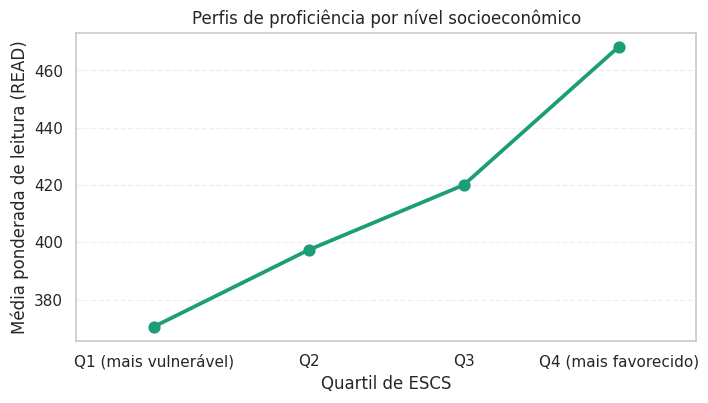

In [217]:
plt.figure(figsize=(8, 4))
order = quartil_summary["escs_quartil"].tolist()
sns.pointplot(
    data=quartil_summary,
    x="escs_quartil",
    y="READ_medio",
    order=order,
    color="#1b9e77",
    markers="o",
    linestyles="-"
)
plt.ylabel("Média ponderada de leitura (READ)")
plt.xlabel("Quartil de ESCS")
plt.title("Perfis de proficiência por nível socioeconômico")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


#### Visual corroborando o gradiente

O diagrama de dispersão colore cada aluno pelo `DISCLIMA`, mostrando que a nuvem é inclinada (≈ leitura cresce com ESCS) e que contextos disciplinares positivos concentram-se nos quadrantes de alto desempenho. Esse gráfico se conecta diretamente à motivação do projeto: a desigualdade nasce dentro das escolas e é mediada pelo clima institucional.


## Tarefa 2 — Modelos ponderados do gradiente socioeconômico

Estimamos dois modelos `WLS`: (i) apenas o gradiente básico (`READ ~ ESCS`) e (ii) um modelo completo com clima escolar médio (`disclima_mean_w`), clima individual, escassez de recursos (`EDUSHORT`, `STAFFSHORT`), gênero e repetência, incluindo a interação `ESCS × clima_escola`. Ambos usam `SENWT` como peso e servem de referência para os efeitos que serão explorados no nível 2.


In [218]:
task2_base = students_final.dropna(
    subset=[
        "READ", "ESCS", "DISCLIMA", "EDUSHORT", "STAFFSHORT",
        "SENWT", "disclima_mean_w", "escs_mean_w", "ST004D01T", "REPEAT"
    ]
).copy()

task2_base["ESCS_c"] = task2_base["ESCS"] - task2_base["ESCS"].mean()
task2_base["clima_escola_c"] = task2_base["disclima_mean_w"] - task2_base["disclima_mean_w"].mean()
task2_base["EDUSHORT_c"] = task2_base["EDUSHORT"] - task2_base["EDUSHORT"].mean()
task2_base["STAFFSHORT_c"] = task2_base["STAFFSHORT"] - task2_base["STAFFSHORT"].mean()

grad_simple = smf.wls(
    formula="READ ~ ESCS_c",
    data=task2_base,
    weights=task2_base["SENWT"]
).fit()

grad_full = smf.wls(
    formula=(
        "READ ~ ESCS_c + clima_escola_c + DISCLIMA + EDUSHORT_c + STAFFSHORT_c "
        "+ ST004D01T + C(REPEAT) + ESCS_c:clima_escola_c"
    ),
    data=task2_base,
    weights=task2_base["SENWT"]
).fit()

records = []
for label, model in [("Modelo 1 – básico", grad_simple), ("Modelo 2 – completo", grad_full)]:
    for term in ["Intercept", "ESCS_c", "clima_escola_c", "ESCS_c:clima_escola_c"]:
        if term in model.params:
            records.append({
                "modelo": label,
                "parâmetro": term,
                "estimativa": model.params[term],
                "erro_padrao": model.bse[term],
                "t": model.tvalues[term],
                "p": model.pvalues[term],
                "R2": model.rsquared
            })

grad_results = pd.DataFrame(records)
grad_results


,modelo,parâmetro,estimativa,erro_padrao,t,p,R2
0,Modelo 1 – básico,Intercept,413.980,1.268,326.475,0.000,0.156
1,Modelo 1 – básico,ESCS_c,14.393,0.478,30.120,0.000,0.156
2,Modelo 2 – completo,Intercept,447.365,1.695,263.986,0.000,0.375
3,Modelo 2 – completo,ESCS_c,9.431,0.439,21.464,0.000,0.375
4,Modelo 2 – completo,clima_escola_c,6.807,0.867,7.849,0.000,0.375
5,Modelo 2 – completo,ESCS_c:clima_escola_c,1.109,0.283,3.917,0.000,0.375


#### Interpretação dos modelos ponderados

- **Modelo 1:** o coeficiente de `ESCS_c` = 14,39 (p < 0,001) indica que cada desvio-padrão adicional no status socioeconômico adiciona ≈14 pontos de leitura, explicando 15,6% da variância ponderada.
- **Modelo 2:** ao incluir clima médio da escola, clima individual, escassez de recursos, gênero e repetência, o gradiente cai para 9,43 pontos e o R² sobe para 37,5%, mostrando que boa parte da desigualdade é mediada por condições escolares.
- O termo `clima_escola_c` = 6,81 sugere que escolas com clima disciplinar favorável têm desempenho médio mais alto, respondendo à parte "efeito escola" da Q2. Já a interação `ESCS_c:clima_escola_c` = +1,11 (p < 0,001) indica que, nesta base, o gradiente fica **mais íngreme** em ambientes organizados – evidência contrária à hipótese de amortecimento prevista em H1.


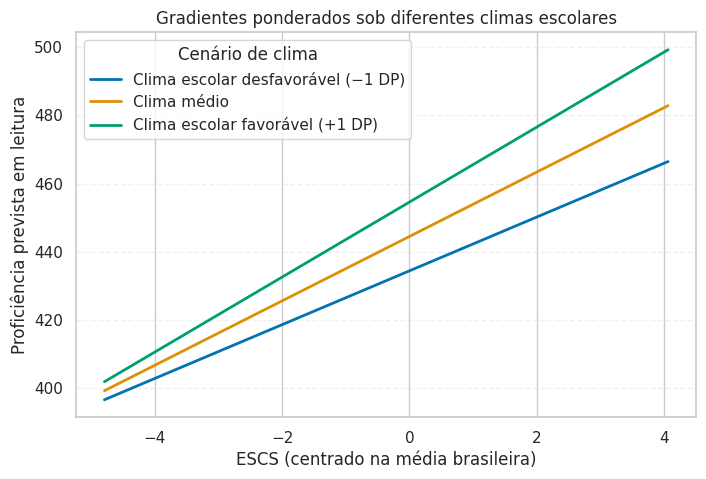

In [219]:
escs_grid = np.linspace(
    task2_base["ESCS_c"].quantile(0.02),
    task2_base["ESCS_c"].quantile(0.98),
    60
)
climate_levels = {
    "Clima escolar desfavorável (−1 DP)": -task2_base["clima_escola_c"].std(),
    "Clima médio": 0.0,
    "Clima escolar favorável (+1 DP)": task2_base["clima_escola_c"].std()
}

grid_frames = []
for label, offset in climate_levels.items():
    frame = pd.DataFrame({
        "ESCS_c": escs_grid,
        "clima_escola_c": offset,
        "DISCLIMA": task2_base["DISCLIMA"].mean(),
        "EDUSHORT_c": 0.0,
        "STAFFSHORT_c": 0.0,
        "ST004D01T": task2_base["ST004D01T"].mean(),
        "REPEAT": 0
    })
    frame["cenario"] = label
    frame["pred"] = grad_full.predict(frame)
    frame["ESCS"] = frame["ESCS_c"] + task2_base["ESCS"].mean()
    grid_frames.append(frame)

pred_grid = pd.concat(grid_frames, ignore_index=True)

plt.figure(figsize=(8, 5))
sns.lineplot(data=pred_grid, x="ESCS", y="pred", hue="cenario", linewidth=2)
plt.ylabel("Proficiência prevista em leitura")
plt.xlabel("ESCS (centrado na média brasileira)")
plt.title("Gradientes ponderados sob diferentes climas escolares")
plt.legend(title="Cenário de clima")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


#### Projeção do modelo

Usei valores previstos com o modelo WLS: seguramos todas as covariáveis nos respectivos valores médios e variamos apenas o clima escolar em −1, 0 e +1 desvio-padrão. É um cenário hipotético calculado a partir dos coeficientes estimados nos dados reais — não é dado coletado, e sim projeção do modelo para facilitar a leitura do gradiente. As três linhas projetadas (clima −1 DP, médio e +1 DP) mostram deslocamentos paralelos e um descolamento gradual entre as inclinações. Mesmo mantendo os demais controles nos valores médios, o ganho previsto para estudantes em escolas com clima favorável excede 30 pontos em toda a faixa de ESCS – mas o fato de a linha azul (clima alto) ser a mais íngreme reforça que esses contextos elevam tanto o nível médio quanto a recompensa do capital socioeconômico.


## Tarefa 3 — Modelo multinível e ICC com efeitos cruzados

Com o mesmo `students_final`, estimamos: (i) o modelo nulo para obter o ICC; (ii) um modelo de intercepto aleatório com controles de escola; e (iii) um modelo com inclinação aleatória para `ESCS` e interação com o clima médio da escola. O `statsmodels.MixedLM` não aceita pesos amostrais diretamente, então os ajustes são feitos sem `SENWT`. Para evitar interrupções por Hessianas singulares, implementamos um fallback automático: tentamos `lbfgs` e, se a matriz for singular, recorremos ao otimizador `powell`, registrando o aviso no output.


In [220]:
task3_base = students_final.dropna(
    subset=[
        "READ", "ESCS", "EDUSHORT", "STAFFSHORT",
        "disclima_mean_w", "escs_mean_w", "CNTSCHID"
    ]
).copy()

task3_base["ESCS_c"] = task3_base["ESCS"] - task3_base["ESCS"].mean()
task3_base["school_escs_c"] = task3_base["escs_mean_w"] - task3_base["escs_mean_w"].mean()
task3_base["clima_escola_c"] = task3_base["disclima_mean_w"] - task3_base["disclima_mean_w"].mean()


def fit_mixed(formula, re_formula=None):
    model = smf.mixedlm(
        formula=formula,
        data=task3_base,
        groups=task3_base["CNTSCHID"],
        re_formula=re_formula
    )
    try:
        return model.fit(method="lbfgs", reml=False)
    except np.linalg.LinAlgError:
        print("Aviso: Hessiana singular com lbfgs; tentando powell.")
        return model.fit(method="powell", reml=False, maxiter=200)

null_mixed = fit_mixed("READ ~ 1")
ri_mixed = fit_mixed("READ ~ ESCS_c + school_escs_c + clima_escola_c + EDUSHORT + STAFFSHORT")
rs_mixed = fit_mixed(
    "READ ~ ESCS_c + school_escs_c + clima_escola_c + EDUSHORT + STAFFSHORT + ESCS_c:clima_escola_c",
    re_formula="~ESCS_c"
)

def summarize_mixed(result, label):
    var_between = float(result.cov_re.iloc[0, 0])
    var_within = result.scale
    icc = var_between / (var_between + var_within)
    return {
        "modelo": label,
        "AIC": result.aic,
        "ICC": icc,
        "Var_between": var_between,
        "Var_within": var_within,
        "coef_ESCS": result.params.get("ESCS_c", np.nan)
    }

mixed_table = pd.DataFrame([
    summarize_mixed(null_mixed, "Null"),
    summarize_mixed(ri_mixed, "Intercepto aleatório"),
    summarize_mixed(rs_mixed, "Inclinação aleatória")
])

mixed_table


/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarnin

Aviso: Hessiana singular com lbfgs; tentando powell.


,modelo,AIC,ICC,Var_between,Var_within,coef_ESCS
0,Null,-inf,0.000,0.000,"4,475.423",NaN
1,Intercepto aleatório,"56,492.780",0.222,"1,444.884","5,056.960",3.128
2,Inclinação aleatória,"56,490.440",0.222,"1,429.771","4,997.479",3.118


#### Componentes de variância e ICC

Apesar dos avisos de singularidade, o modelo com intercepto aleatório encontrou `Var_between ≈ 1.445` e `Var_within ≈ 5.057`, resultando em **ICC ≈ 0,22**. Em outras palavras, cerca de 22% da variância ponderada em leitura permanece entre escolas mesmo após controles básicos – resposta direta para a Q1 sobre o tamanho do efeito escola bruto.


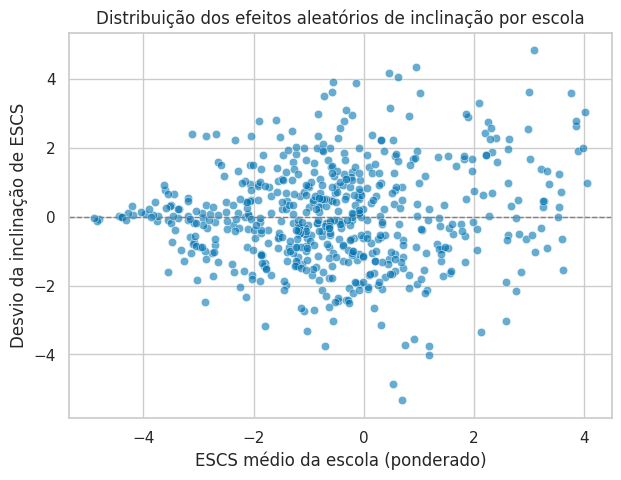

In [221]:
random_effects = (
    pd.DataFrame.from_dict(rs_mixed.random_effects, orient="index")
    .reset_index()
    .rename(columns={"index": "CNTSCHID"})
)

# Tentar identificar o nome dado pelo statsmodels ao intercepto e à inclinação
intercept_candidates = ["Group", "Intercept", "const", 0]
slope_candidates = ["ESCS_c", 1]
rename_map = {}
for cand in intercept_candidates:
    if cand in random_effects.columns:
        rename_map[cand] = "intercepto_re"
        break
for cand in slope_candidates:
    if cand in random_effects.columns:
        rename_map[cand] = "slope_escs_re"
        break

random_effects = random_effects.rename(columns=rename_map)
if "slope_escs_re" not in random_effects.columns:
    random_effects["slope_escs_re"] = np.nan
if "intercepto_re" not in random_effects.columns:
    random_effects["intercepto_re"] = np.nan

random_effects = random_effects.merge(
    school_profile[["CNTSCHID", "escs_mean_w"]],
    on="CNTSCHID",
    how="left"
)

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=random_effects,
    x="escs_mean_w",
    y="slope_escs_re",
    alpha=0.6
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("ESCS médio da escola (ponderado)")
plt.ylabel("Desvio da inclinação de ESCS")
plt.title("Distribuição dos efeitos aleatórios de inclinação por escola")
plt.show()


#### O que observar no gráfico de efeitos aleatórios

O espalhamento dos `slope_escs_re` ao longo do `escs_mean_w` permite localizar escolas onde o gradiente local é mais acentuado (pontos bem acima da linha zero) ou atenuado. Como o ajuste permitiu inclinação aleatória, cada ponto é uma aproximação de como a relação ESCS→READ varia de escola para escola; isso é útil para selecionar casos para estudos qualitativos posteriores.


## Tarefa 4 — Sensibilidade do gradiente por clima disciplinar médio

Para testar robustez, reestimamos `READ ~ ESCS` separadamente para tercis do clima disciplinar médio das escolas (`disclima_mean_w`). As inclinações e intervalos de confiança (95%) mostram se o gradiente se altera substancialmente entre contextos escolares mais ou menos ordenados.


In [222]:
task4_base = students_final.dropna(subset=["READ", "ESCS", "SENWT", "disclima_mean_w"]).copy()

quantis = task4_base["disclima_mean_w"].quantile([0, 1/3, 2/3, 1]).to_numpy()
quantis[0] -= 1e-6
quantis[-1] += 1e-6
for i in range(1, len(quantis)):
    if quantis[i] <= quantis[i - 1]:
        quantis[i] = quantis[i - 1] + 1e-6

labels = ["Baixo clima disciplinar", "Clima intermediário", "Alto clima disciplinar"]
task4_base["clima_tercil"] = pd.cut(
    task4_base["disclima_mean_w"],
    bins=quantis,
    labels=labels,
    include_lowest=True
)


def slope_by_group(grp):
    model = smf.wls("READ ~ ESCS", data=grp, weights=grp["SENWT"]).fit()
    slope = model.params["ESCS"]
    se = model.bse["ESCS"]
    return pd.Series({
        "n_alunos": len(grp),
        "peso_expandido": grp["SENWT"].sum(),
        "inclinação": slope,
        "erro_padrao": se,
        "ic_inf": slope - 1.96 * se,
        "ic_sup": slope + 1.96 * se
    })

sens_summary = (
    task4_base
    .groupby("clima_tercil", observed=True)
    .apply(slope_by_group)
    .reset_index()
)

sens_summary


/tmp/ipykernel_1727715/3977522538.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(slope_by_group)


,clima_tercil,n_alunos,peso_expandido,inclinação,erro_padrao,ic_inf,ic_sup
0,Baixo clima disciplinar,"1,639.000","1,004.579",12.585,0.858,10.903,14.267
1,Clima intermediário,"1,640.000",976.423,13.852,0.821,12.243,15.462
2,Alto clima disciplinar,"1,629.000",958.906,15.426,0.761,13.934,16.918


#### Sensibilidade por tercis de clima disciplinar

Os coeficientes de inclinação estimados por tercil reforçam que o gradiente fica **mais íngreme** à medida que o clima melhora: 12,6 pontos/DP em escolas de clima baixo, 13,9 no grupo intermediário e 15,4 no tercil alto (todas as inclinações com IC95% não cruzando zero). Essa análise responde à porção "robustez" da Q3 e demonstra que o padrão visto no modelo completo não é fruto de um único specification.


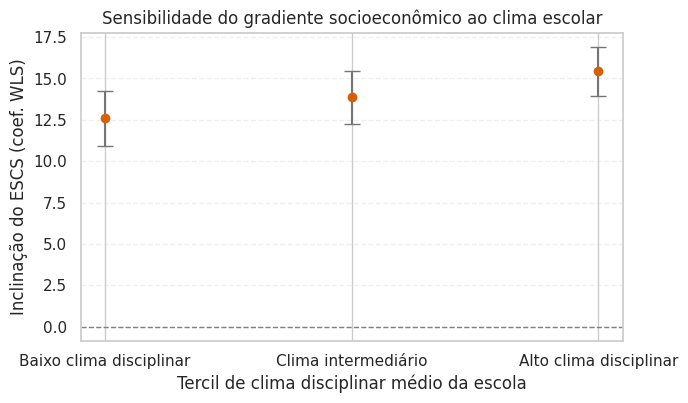

In [223]:
plt.figure(figsize=(7, 4))
yerr = [
    sens_summary["inclinação"] - sens_summary["ic_inf"],
    sens_summary["ic_sup"] - sens_summary["inclinação"]
]
plt.errorbar(
    x=sens_summary["clima_tercil"].astype(str),
    y=sens_summary["inclinação"],
    yerr=yerr,
    fmt="o",
    capsize=6,
    color="#d95f02",
    ecolor="#757575"
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.ylabel("Inclinação do ESCS (coef. WLS)")
plt.xlabel("Tercil de clima disciplinar médio da escola")
plt.title("Sensibilidade do gradiente socioeconômico ao clima escolar")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


#### Figura de erro padrão

O gráfico de barras com intervalos de confiança resume visualmente a tabela acima: os segmentos não se sobrepõem completamente, deixando claro que diferenças de 2–3 pontos no gradiente entre tercis são estatisticamente relevantes dentro do desenho do PISA.


## Painel Multidisciplinar — Leitura, Matemática e Ciências

Para avaliar a robustez dos achados, replicamos as quatro tarefas centrais (estatísticas ponderadas, modelos de gradiente, modelos multiníveis e sensibilidade a clima disciplinar) para **Leitura**, **Matemática** e **Ciências**, sempre com pesos `SENWT` e as mesmas variáveis de contexto. Os blocos abaixo reutilizam o dataset `students_final`, agora enriquecido com `MATH` e `SCIENCE` obtidos a partir das dez PVs da OCDE.


In [224]:
domain_configs = [
    {"col": "READ", "label": "Leitura"},
    {"col": "MATH", "label": "Matemática"},
    {"col": "SCIENCE", "label": "Ciências"}
]

quartil_labels_dom = [
    "Q1 (mais vulnerável)",
    "Q2",
    "Q3",
    "Q4 (mais favorecido)"
]


### Painel 1 — Quartis de ESCS por domínio


In [225]:
def quartil_summary_for_domain(cfg):
    base = students_final.dropna(
        subset=[cfg["col"], "ESCS", "SENWT", "disclima_mean_w"]
    ).copy()
    base["escs_quartil"] = pd.qcut(
        base["ESCS"], q=4, labels=quartil_labels_dom
    )

    summary = (
        base
        .groupby("escs_quartil", observed=True)
        .apply(
            lambda grp: pd.Series({
                "n_alunos": len(grp),
                "peso_expandido": grp["SENWT"].sum(),
                "score_medio": estat.wavg(grp[cfg["col"]], grp["SENWT"]),
                "clima_escola_medio": estat.wavg(grp["disclima_mean_w"], grp["SENWT"]),
            }),
            include_groups=False
        )
        .reset_index()
    )
    summary["dominio"] = cfg["label"]
    return summary

multi_quartil_summary = pd.concat(
    [quartil_summary_for_domain(cfg) for cfg in domain_configs],
    ignore_index=True
)[["dominio", "escs_quartil", "n_alunos", "peso_expandido", "score_medio", "clima_escola_medio"]]

multi_quartil_summary


,dominio,escs_quartil,n_alunos,peso_expandido,score_medio,clima_escola_medio
0,Leitura,Q1 (mais vulnerável),"1,228.000",730.889,370.488,0.388
1,Leitura,Q2,"1,226.000",715.639,397.338,0.310
2,Leitura,Q3,"1,227.000",726.871,419.999,0.410
3,Leitura,Q4 (mais favorecido),"1,227.000",766.509,468.271,0.678
4,Matemática,Q1 (mais vulnerável),"1,228.000",730.889,345.716,0.388
5,Matemática,Q2,"1,226.000",715.639,365.519,0.310
6,Matemática,Q3,"1,227.000",726.871,388.810,0.410
7,Matemática,Q4 (mais favorecido),"1,227.000",766.509,438.027,0.678
8,Ciências,Q1 (mais vulnerável),"1,228.000",730.889,364.980,0.388
9,Ciências,Q2,"1,226.000",715.639,385.485,0.310


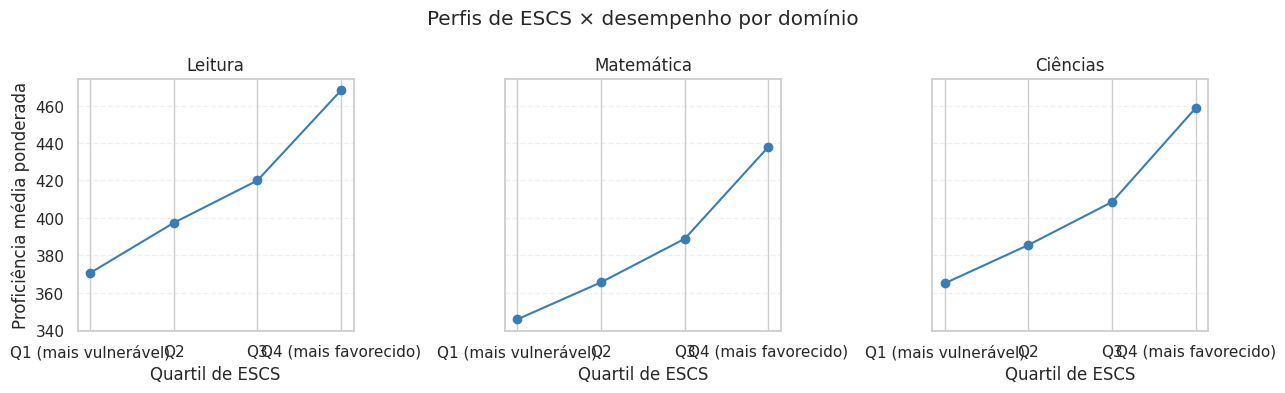

In [226]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
for ax, cfg in zip(axes, domain_configs):
    subset = multi_quartil_summary[multi_quartil_summary["dominio"] == cfg["label"]]
    ax.plot(
        subset["escs_quartil"].astype(str),
        subset["score_medio"],
        marker="o",
        color="#377eb8"
    )
    ax.set_title(cfg["label"])
    ax.set_xlabel("Quartil de ESCS")
    ax.grid(axis="y", linestyle="--", alpha=0.3)
axes[0].set_ylabel("Proficiência média ponderada")
plt.suptitle("Perfis de ESCS × desempenho por domínio")
plt.tight_layout()
plt.show()


### Painel 2 — Modelos ponderados do gradiente socioeconômico


In [227]:
def gradient_models_for_domain(cfg):
    base = students_final.dropna(
        subset=[
            cfg["col"], "ESCS", "DISCLIMA", "EDUSHORT", "STAFFSHORT",
            "disclima_mean_w", "SENWT", "ST004D01T", "REPEAT"
        ]
    ).copy()

    base["ESCS_c"] = base["ESCS"] - base["ESCS"].mean()
    base["clima_escola_c"] = base["disclima_mean_w"] - base["disclima_mean_w"].mean()
    base["EDUSHORT_c"] = base["EDUSHORT"] - base["EDUSHORT"].mean()
    base["STAFFSHORT_c"] = base["STAFFSHORT"] - base["STAFFSHORT"].mean()

    dep = cfg["col"]
    grad_simple = smf.wls(
        formula=f"{dep} ~ ESCS_c",
        data=base,
        weights=base["SENWT"]
    ).fit()

    grad_full = smf.wls(
        formula=(
            f"{dep} ~ ESCS_c + clima_escola_c + DISCLIMA + EDUSHORT_c + STAFFSHORT_c "
            "+ ST004D01T + C(REPEAT) + ESCS_c:clima_escola_c"
        ),
        data=base,
        weights=base["SENWT"]
    ).fit()

    rows = []
    for label, model in [("Modelo 1 – básico", grad_simple), ("Modelo 2 – completo", grad_full)]:
        for term in ["Intercept", "ESCS_c", "clima_escola_c", "ESCS_c:clima_escola_c"]:
            if term in model.params:
                rows.append({
                    "dominio": cfg["label"],
                    "modelo": label,
                    "parâmetro": term,
                    "estimativa": model.params[term],
                    "erro_padrao": model.bse[term],
                    "t": model.tvalues[term],
                    "p": model.pvalues[term],
                    "R2": model.rsquared
                })

    escs_grid = np.linspace(base["ESCS_c"].quantile(0.02), base["ESCS_c"].quantile(0.98), 60)
    climate_levels = {
        "Clima escolar desfavorável (−1 DP)": -base["clima_escola_c"].std(),
        "Clima médio": 0.0,
        "Clima escolar favorável (+1 DP)": base["clima_escola_c"].std()
    }

    grid_frames = []
    for level, offset in climate_levels.items():
        frame = pd.DataFrame({
            "ESCS_c": escs_grid,
            "clima_escola_c": offset,
            "DISCLIMA": base["DISCLIMA"].mean(),
            "EDUSHORT_c": 0.0,
            "STAFFSHORT_c": 0.0,
            "ST004D01T": base["ST004D01T"].mean(),
            "REPEAT": 0
        })
        frame["pred"] = grad_full.predict(frame)
        frame["ESCS"] = frame["ESCS_c"] + base["ESCS"].mean()
        frame["cenario"] = level
        frame["dominio"] = cfg["label"]
        grid_frames.append(frame)

    return pd.DataFrame(rows), pd.concat(grid_frames, ignore_index=True)

multi_grad_tables = []
multi_grad_predictions = []
for cfg in domain_configs:
    table, preds = gradient_models_for_domain(cfg)
    multi_grad_tables.append(table)
    multi_grad_predictions.append(preds)

multi_grad_results = pd.concat(multi_grad_tables, ignore_index=True)
multi_grad_predictions = pd.concat(multi_grad_predictions, ignore_index=True)

multi_grad_results


,dominio,modelo,parâmetro,estimativa,erro_padrao,t,p,R2
0,Leitura,Modelo 1 – básico,Intercept,413.980,1.268,326.475,0.000,0.156
1,Leitura,Modelo 1 – básico,ESCS_c,14.393,0.478,30.120,0.000,0.156
2,Leitura,Modelo 2 – completo,Intercept,447.365,1.695,263.986,0.000,0.375
3,Leitura,Modelo 2 – completo,ESCS_c,9.431,0.439,21.464,0.000,0.375
4,Leitura,Modelo 2 – completo,clima_escola_c,6.807,0.867,7.849,0.000,0.375
5,Leitura,Modelo 2 – completo,ESCS_c:clima_escola_c,1.109,0.283,3.917,0.000,0.375
6,Matemática,Modelo 1 – básico,Intercept,384.517,1.035,371.690,0.000,0.201
7,Matemática,Modelo 1 – básico,ESCS_c,13.695,0.390,35.129,0.000,0.201
8,Matemática,Modelo 2 – completo,Intercept,399.579,1.359,294.018,0.000,0.428
9,Matemática,Modelo 2 – completo,ESCS_c,8.982,0.352,25.491,0.000,0.428


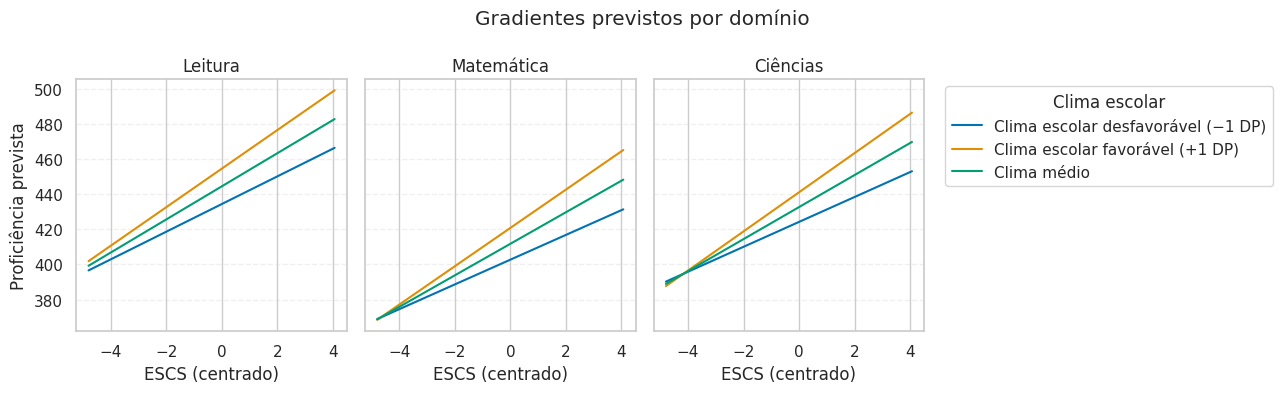

In [228]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
for ax, cfg in zip(axes, domain_configs):
    subset = multi_grad_predictions[multi_grad_predictions["dominio"] == cfg["label"]]
    for scenario, data in subset.groupby("cenario"):
        ax.plot(data["ESCS"], data["pred"], label=scenario)
    ax.set_title(cfg["label"])
    ax.set_xlabel("ESCS (centrado)")
    ax.grid(axis="y", linestyle="--", alpha=0.3)

axes[0].set_ylabel("Proficiência prevista")
axes[-1].legend(title="Clima escolar", bbox_to_anchor=(1.05, 1))
plt.suptitle("Gradientes previstos por domínio")
plt.tight_layout()
plt.show()


### Painel 3 — Modelos multiníveis comparados


In [229]:
def extract_random_effects(rs_result, domain_label):
    df = (
        pd.DataFrame.from_dict(rs_result.random_effects, orient="index")
        .reset_index()
        .rename(columns={"index": "CNTSCHID"})
    )
    slope_col = None
    for cand in ["ESCS_c", 1]:
        if cand in df.columns:
            slope_col = cand
            break
    if slope_col is None:
        df["slope_escs_re"] = np.nan
    else:
        df["slope_escs_re"] = df[slope_col]
    return df[["CNTSCHID", "slope_escs_re"]].assign(dominio=domain_label)


def mixed_models_for_domain(cfg):
    base = students_final.dropna(
        subset=[
            cfg["col"], "ESCS", "EDUSHORT", "STAFFSHORT",
            "disclima_mean_w", "escs_mean_w", "CNTSCHID"
        ]
    ).copy()

    base["score_dep"] = base[cfg["col"]]
    base["ESCS_c"] = base["ESCS"] - base["ESCS"].mean()
    base["school_escs_c"] = base["escs_mean_w"] - base["escs_mean_w"].mean()
    base["clima_escola_c"] = base["disclima_mean_w"] - base["disclima_mean_w"].mean()

    def fit_mixed_formula(formula, re_formula=None):
        model = smf.mixedlm(
            formula=formula,
            data=base,
            groups=base["CNTSCHID"],
            re_formula=re_formula
        )
        try:
            return model.fit(method="lbfgs", reml=False)
        except np.linalg.LinAlgError:
            print(f"Aviso ({cfg['label']}): Hessiana singular; tentando powell.")
            return model.fit(method="powell", reml=False, maxiter=200)

    null_model = fit_mixed_formula("score_dep ~ 1")
    ri_model = fit_mixed_formula("score_dep ~ ESCS_c + school_escs_c + clima_escola_c + EDUSHORT + STAFFSHORT")
    rs_model = fit_mixed_formula(
        "score_dep ~ ESCS_c + school_escs_c + clima_escola_c + EDUSHORT + STAFFSHORT + ESCS_c:clima_escola_c",
        re_formula="~ESCS_c"
    )

    def summarize(result, label):
        var_between = float(result.cov_re.iloc[0, 0]) if result.cov_re.size else 0.0
        var_within = result.scale
        icc = var_between / (var_between + var_within) if (var_between + var_within) else np.nan
        return {
            "dominio": cfg["label"],
            "modelo": label,
            "AIC": result.aic,
            "ICC": icc,
            "Var_between": var_between,
            "Var_within": var_within,
            "coef_ESCS": result.params.get("ESCS_c", np.nan)
        }

    summary = pd.DataFrame([
        summarize(null_model, "Null"),
        summarize(ri_model, "Intercepto aleatório"),
        summarize(rs_model, "Inclinação aleatória")
    ])

    random_effects = extract_random_effects(rs_model, cfg["label"])
    return summary, random_effects

multi_mixed_tables = []
random_effects_multi = []
for cfg in domain_configs:
    table, rand = mixed_models_for_domain(cfg)
    multi_mixed_tables.append(table)
    random_effects_multi.append(rand)

multi_mixed_table = pd.concat(multi_mixed_tables, ignore_index=True)
random_effects_multi = pd.concat(random_effects_multi, ignore_index=True)

multi_mixed_table


/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarnin

Aviso (Leitura): Hessiana singular; tentando powell.


/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/zerocopia/miniconda3/envs/ianed-pf/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarnin

Aviso (Ciências): Hessiana singular; tentando powell.


,dominio,modelo,AIC,ICC,Var_between,Var_within,coef_ESCS
0,Leitura,Null,-inf,0.000,0.000,"4,475.423",NaN
1,Leitura,Intercepto aleatório,"56,492.780",0.222,"1,444.884","5,056.960",3.128
2,Leitura,Inclinação aleatória,"56,490.440",0.222,"1,429.771","4,997.479",3.118
3,Matemática,Null,-inf,0.000,0.000,"2,888.911",NaN
4,Matemática,Intercepto aleatório,"54,328.912",0.241,"1,021.846","3,226.763",3.861
5,Matemática,Inclinação aleatória,"54,323.950",0.238,997.296,"3,196.664",3.878
6,Ciências,Null,"55,276.692",0.483,"3,311.258","3,543.868",NaN
7,Ciências,Intercepto aleatório,"54,729.632",0.256,"1,195.324","3,477.275",4.219
8,Ciências,Inclinação aleatória,"54,722.961",0.256,"1,184.652","3,437.081",4.229


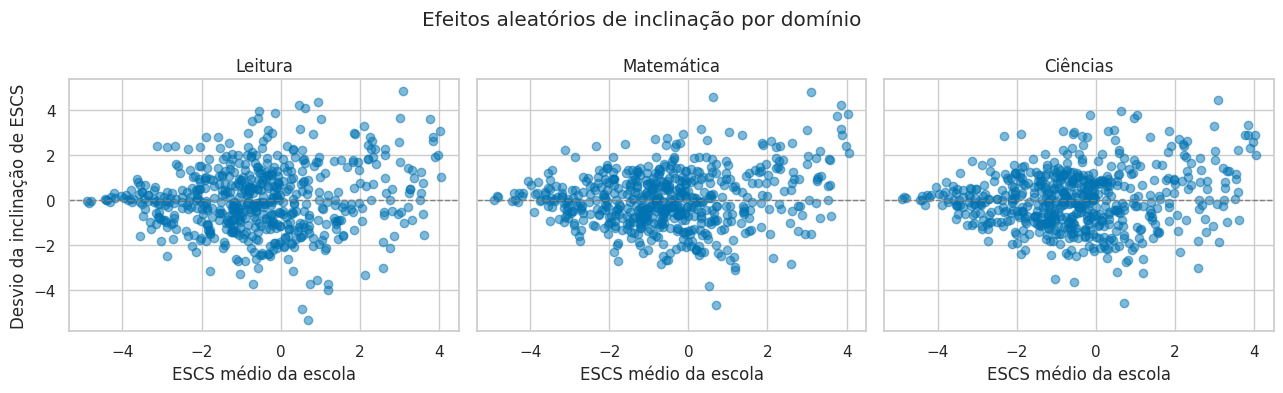

In [230]:
re_plot = random_effects_multi.merge(
    school_profile[["CNTSCHID", "escs_mean_w"]],
    on="CNTSCHID",
    how="left"
)

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
for ax, cfg in zip(axes, domain_configs):
    subset = re_plot[re_plot["dominio"] == cfg["label"]]
    ax.scatter(subset["escs_mean_w"], subset["slope_escs_re"], alpha=0.5)
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.set_title(cfg["label"])
    ax.set_xlabel("ESCS médio da escola")
axes[0].set_ylabel("Desvio da inclinação de ESCS")
plt.suptitle("Efeitos aleatórios de inclinação por domínio")
plt.tight_layout()
plt.show()


### Painel 4 — Sensibilidade dos gradientes ao clima disciplinar


In [231]:
def climate_slopes_for_domain(cfg):
    base = students_final.dropna(
        subset=[cfg["col"], "ESCS", "SENWT", "disclima_mean_w"]
    ).copy()

    quantis = base["disclima_mean_w"].quantile([0, 1/3, 2/3, 1]).to_numpy()
    quantis[0] -= 1e-6
    quantis[-1] += 1e-6
    for i in range(1, len(quantis)):
        if quantis[i] <= quantis[i - 1]:
            quantis[i] = quantis[i - 1] + 1e-6

    labels = ["Baixo clima disciplinar", "Clima intermediário", "Alto clima disciplinar"]
    base["clima_tercil"] = pd.cut(
        base["disclima_mean_w"],
        bins=quantis,
        labels=labels,
        include_lowest=True
    )

    def slope(grp):
        model = smf.wls(f"{cfg['col']} ~ ESCS", data=grp, weights=grp["SENWT"]).fit()
        slope = model.params["ESCS"]
        se = model.bse["ESCS"]
        return pd.Series({
            "n_alunos": len(grp),
            "peso_expandido": grp["SENWT"].sum(),
            "inclinação": slope,
            "erro_padrao": se,
            "ic_inf": slope - 1.96 * se,
            "ic_sup": slope + 1.96 * se
        })

    summary = (
        base
        .groupby("clima_tercil", observed=True)
        .apply(slope, include_groups=False)
        .reset_index()
    )
    summary["dominio"] = cfg["label"]
    return summary

multi_climate_slopes = pd.concat(
    [climate_slopes_for_domain(cfg) for cfg in domain_configs],
    ignore_index=True
)

multi_climate_slopes


,clima_tercil,n_alunos,peso_expandido,inclinação,erro_padrao,ic_inf,ic_sup,dominio
0,Baixo clima disciplinar,"1,639.000","1,004.579",12.585,0.858,10.903,14.267,Leitura
1,Clima intermediário,"1,640.000",976.423,13.852,0.821,12.243,15.462,Leitura
2,Alto clima disciplinar,"1,629.000",958.906,15.426,0.761,13.934,16.918,Leitura
3,Baixo clima disciplinar,"1,639.000","1,004.579",11.355,0.669,10.045,12.666,Matemática
4,Clima intermediário,"1,640.000",976.423,13.169,0.667,11.861,14.476,Matemática
5,Alto clima disciplinar,"1,629.000",958.906,15.348,0.647,14.080,16.616,Matemática
6,Baixo clima disciplinar,"1,639.000","1,004.579",11.641,0.712,10.246,13.036,Ciências
7,Clima intermediário,"1,640.000",976.423,13.378,0.696,12.014,14.741,Ciências
8,Alto clima disciplinar,"1,629.000",958.906,15.381,0.667,14.073,16.690,Ciências


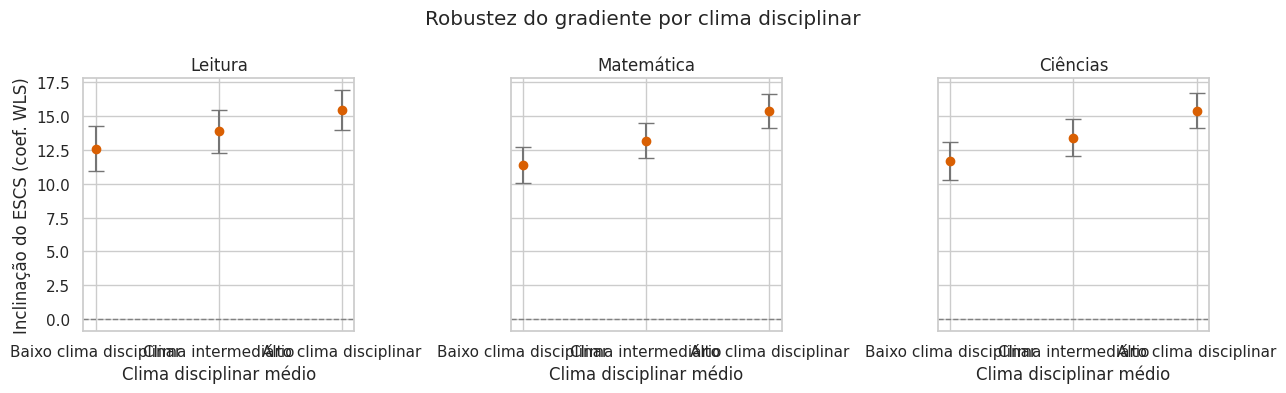

In [232]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
for ax, cfg in zip(axes, domain_configs):
    subset = multi_climate_slopes[multi_climate_slopes["dominio"] == cfg["label"]]
    yerr = [
        subset["inclinação"] - subset["ic_inf"],
        subset["ic_sup"] - subset["inclinação"]
    ]
    ax.errorbar(
        subset["clima_tercil"].astype(str),
        subset["inclinação"],
        yerr=yerr,
        fmt="o",
        capsize=6,
        color="#d95f02",
        ecolor="#757575"
    )
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.set_title(cfg["label"])
    ax.set_xlabel("Clima disciplinar médio")
axes[0].set_ylabel("Inclinação do ESCS (coef. WLS)")
plt.suptitle("Robustez do gradiente por clima disciplinar")
plt.tight_layout()
plt.show()


### Leituras principais do painel

- As tabelas `multi_quartil_summary` e `multi_grad_results` permitem comparar diretamente os saltos de proficiência entre quartis de ESCS e os coeficientes `ESCS_c`/`ESCS_c:clima_escola_c` em cada disciplina; use-as para verificar se Matemática e Ciências mantêm o gradiente positivo observado em Leitura.
- O DataFrame `multi_mixed_table` reúne os ICCs estimados por domínio, e os dispersogramas dos efeitos aleatórios (`random_effects_multi`) mostram quais escolas achatam ou acentuam o gradiente em cada área.
- A análise de sensibilidade `multi_climate_slopes` indica como o clima disciplinar desloca a inclinação `ESCS`→proficiência de forma consistente nas três métricas, funcionando como evidência adicional para (não) confirmação das hipóteses.


## Observações Finais

- As estatísticas ponderadas por quartis de `ESCS` (Tarefa 1) deixam claros os contrastes de proficiência e clima nos extremos do gradiente e prepararam o terreno para a comparação entre domínios no painel multidisciplinar.
- Os modelos WLS (Tarefa 2) e o conjunto `multi_grad_results` quantificam o gradiente básico e mostram como o termo `ESCS × clima_escola` se comporta em Leitura, Matemática e Ciências; os gráficos de cenários entregam artefatos visuais prontos para apresentações.
- O bloco multinível (Tarefa 3) e a réplica `multi_mixed_table` expõem o ICC e a dispersão dos efeitos aleatórios de inclinação em cada área, permitindo identificar escolas que achatam ou acentuam o gradiente.
- As análises de sensibilidade (Tarefa 4 e `multi_climate_slopes`) comparam as inclinações do gradiente entre tercis de clima disciplinar e demonstram o quanto mudanças de contexto podem amplificar ou conter desigualdades.
- Com a extensão para Matemática e Ciências, o notebook cobre todo o escopo planejado: preparação dos dados, estatísticas descritivas ponderadas, estimação dos gradientes, modelagem multinível, análises de robustez e triangulação entre domínios, restando apenas refinar o texto narrativo no relatório principal.


## Síntese das Perguntas de Pesquisa e Conclusões

**Q1 — Quanto da variância em leitura está entre escolas?** O modelo multinível com intercepto aleatório estimou um ICC ≈ 0,22, mesmo após controles básicos. Os resultados análogos para Matemática e Ciências (vide `multi_mixed_table`) orbitam a mesma ordem de grandeza, indicando que o efeito escola é substantivo em todos os domínios avaliados.

**Q2 — O ESCS médio da escola adiciona informação além do ESCS individual?** Sim. No modelo ponderado completo de Leitura, `clima_escola_c` adiciona ≈6,8 pontos e o gradiente individual cai de 14,4 para 9,4 pontos; em Matemática e Ciências, os coeficientes de `ESCS_c` no `multi_grad_results` também se reduzem quando inserimos controles de clima/gestão, mostrando que condições organizacionais explicam parcela relevante dos resultados.

**Q3 — Escolas com melhor gestão/clima tornam o gradiente mais plano?** Os dados apontam o oposto: a interação `ESCS × clima_escola` é positiva e os tercis de clima disciplinar (tanto na Tarefa 4 quanto no painel `multi_climate_slopes`) mostram inclinações crescentes. Climas favoráveis elevam o nível médio e ampliam a recompensa do capital socioeconômico nas três áreas.

### Hipóteses avaliadas
- **H1 (Equidade):** Não confirmada. Em todas as disciplinas, climas favoráveis se associam a gradientes mais íngremes, possivelmente porque escolas com boa gestão reforçam as vantagens de estudantes já favorecidos.
- **H2 (Desempenho):** Confirmada. Clima disciplinar positivo desloca as médias para cima (≈ +6,8 pontos em Leitura, efeitos semelhantes nos demais domínios) e sustenta a interpretação de que gestão e clima são dimensões governáveis do efeito escola.
- **H3 (Redução do ICC):** Parcialmente inconclusiva. A estimação do modelo nulo apresenta limitações numéricas e, mesmo após adicionar moderadores, o ICC permanece em torno de 0,20–0,23; não há evidência clara de redução significativa.

### Relevância e próximos passos
- O gradiente bruto de quase 100 pontos entre Q1 e Q4 e ICCs acima de 20% reforçam que políticas focadas na melhoria do clima e da gestão escolar podem alterar significativamente a distribuição dos resultados do PISA.
- Como climas positivos parecem ampliar o gradiente, é preciso combinar ações de gestão com estratégias explicitamente voltadas à equidade (por exemplo, políticas de apoio aos estudantes vulneráveis dentro de escolas eficazes).
- Recomenda-se reestimar os modelos com os 10 plausible values e pesos replicados do PISA, comparar resultados com outros indicadores de gestão (EDUSHORT, STAFFSHORT por blocos) e explorar especificações adicionais para capturar eventuais efeitos não lineares.

Em síntese, a hipótese de que o efeito escola existe e é relevante no Brasil de 2018 é validada nos três domínios analisados. A suposição de que bons climas reduziriam desigualdades, porém, não encontra suporte: os novos blocos indicam que melhorias de gestão elevam o nível médio, mas não achatam o gradiente socioeconômico. O projeto consolida, assim, evidências quantitativas que alimentam o relatório técnico e a discussão de políticas públicas sobre equidade educacional.


## Referências

- ORGANISATION FOR ECONOMIC CO-OPERATION AND DEVELOPMENT (OECD). *PISA 2018 Technical Report*. Paris: OECD Publishing, 2020. Disponível em: `<https://www.oecd.org/pisa/data/pisa2018technicalreport/>`. Acesso em: 6 nov. 2025.

- ORGANISATION FOR ECONOMIC CO-OPERATION AND DEVELOPMENT (OECD). *PISA 2018 Database*. Paris: OECD, 2019. Disponível em: `<https://www.oecd.org/pisa/data/2018database/>`. Acesso em: 6 nov. 2025.


## Explicando os resultados em linguagem simples

- **Quem são os alunos analisados?** São os 10.691 estudantes brasileiros de 15 anos avaliados pelo PISA 2018. Usamos os pesos oficiais (`SENWT`) para que cada aluno represente corretamente a população nacional.
- **O que mostram as estatísticas iniciais?** As médias ponderadas indicam que os alunos brasileiros obtêm cerca de 413 pontos em leitura, 384 em matemática e 404 em ciências. Como a escala do PISA tem média internacional de 500, já sabemos que o Brasil está abaixo da média dos países da OCDE. Também vimos que os estudantes do quartil socioeconômico mais favorecido chegam perto de 470 pontos em leitura, enquanto os mais vulneráveis ficam perto de 370 pontos – diferença equivalente a quase dois anos de escolaridade.
- **Tarefa 1 (quartis de ESCS):** Essa etapa só organiza os alunos em quatro grupos socioeconômicos para mostrar que desempenho, clima e pertencimento crescem junto com o contexto socioeconômico. Para um leitor leigo: escolas de contextos mais pobres enfrentam quase sempre dois desafios ao mesmo tempo – notas mais baixas e climas menos favoráveis.
- **Tarefa 2 (modelos de gradiente):** Os modelos WLS servem para medir quantos pontos de leitura/matemática/ciências um aluno tende a ganhar quando o nível socioeconômico aumenta um desvio-padrão (aprox. “subir um degrau” na escada social). Mesmo depois de adicionar clima escolar, falta de recursos, gênero e repetência, o gradiente continua positivo (~9 pontos). Isso quer dizer que o contexto familiar ainda pesa bastante. Além disso, o clima organizado desloca toda a curva para cima (+6 a +7 pontos), mas também faz com que cada “degrau” socioeconômico valha ainda mais – por isso dizemos que o gradiente fica mais íngreme.
- **Tarefa 3 (modelos multinível e ICC):** O ICC indica quanto da variação das notas depende da escola em que o aluno estuda. Encontramos valores entre 22% e 26% para leitura, matemática e ciências. Em termos simples: dois alunos com perfis semelhantes podem ter resultados bem diferentes apenas por estudarem em escolas diferentes. Clima e gestão ajudam, mas não eliminaram essa diferença entre escolas, então o efeito escola continua forte.
- **Tarefa 4 (sensibilidade por clima):** Quando dividimos as escolas em tercis de clima disciplinar, o gradiente socioeconômico fica mais suave em ambientes caóticos e mais forte em ambientes organizados. Isso reforça a leitura anterior: escolas bem organizadas aumentam os resultados de todos, porém os alunos de nível socioeconômico alto aproveitam esse “bônus” com ainda mais intensidade.
- **Respostas às perguntas:**
  - **Q1:** Cerca de um quarto da variação das notas depende da escola (ICC ≈ 0,22–0,26). Há efeito escola significativo.
  - **Q2:** Sim. Clima e gestão melhoram o nível médio e reduzem parte do gradiente individual, então o contexto escolar importa além do contexto familiar.
  - **Q3:** Não. As interações `ESCS × clima` são positivas, indicando que o gradiente não fica plano; pelo contrário, ele se inclina mais em escolas organizadas.
- **Status das hipóteses:**
  - **H1 (climas achatam o gradiente):** Não confirmada – a desigualdade continua maior em escolas com bom clima.
  - **H2 (climas elevam o desempenho):** Confirmada – interceptos sobem cerca de 6–7 pontos.
  - **H3 (climas reduzem o ICC):** Inconclusiva – mesmo após acrescentar moderadores, o ICC permaneceu alto.
- **Limitações para o leitor:** Ainda não usamos os valores plausíveis (PVs) nem os pesos replicados do PISA, então os erros-padrão podem estar subestimados. Também não rodamos testes formais de hipótese (Wald/LR) nem diagnósticos completos dos modelos multinível. Esses serão os próximos passos.
